###same as the standard DMD algorithm in Tu, also use velocity oberservations

In [1]:
include("/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/foamLia.jl")
using foamLia

baseCase = OpenFoam("/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase");
initCase(baseCase,"/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/juliabase/");
faces,cells = readMesh(baseCase);
points,indices = reshapeMesh(baseCase);

# let's go get the foward four points of each cell
# only get the yz coordinates
cellPoints = zeros(size(baseCase.fullMesh["cellFaces"])[2],4,3)
for cellID in 1:size(baseCase.fullMesh["cellFaces"])[2]
    faces_tmp = baseCase.fullMesh["cellFaces"][:,cellID]
    # println(faces)
    pointList = Int[]
    for faceID in 1:6
        face = faces_tmp[faceID]
        pointIDs = baseCase.fullMesh["faces"][:,face]
        # println(pointIDs)
        for pointID in 1:4
            point = pointIDs[pointID]
            if point ∉ pointList
                push!(pointList,point)
            end
        end
    end
    # println(pointList)
    # print(size(pointList))
    j = 0
    for (i,point) in enumerate(pointList)
        # println(i)
        # println(point)
        # println(baseCase.fullMesh["points"][:,point])
        pointXYZ = baseCase.fullMesh["points"][:,point]
        if pointXYZ[1] > 0
            j += 1
            cellPoints[cellID,j,:] = pointXYZ
        end
    end
end


/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase/system exists
/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase/constant/polyMesh exists
/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase/0 exists
copying over base case
writing out controlDict
writing out fvSchemes
writing out fvSolution
writing out setFieldsDict
writing out RASProperties
writing out transportProperties
writing out turbulenceProperties
writing out g
writing out T
writing out phi
writing out U
writing out p


In [48]:
# all of the function that are necessary for plotting
using PyPlot
using PyCall
@pyimport matplotlib as mpl
patches = mpl.pymember("patches")

RdYlBu = readcsv("/Users/andyreagan/work/2014/11-foamLab-julia/RdYlBu.csv");
function cmapper(cmap,val)
    squeeze(cmap[min(max(ceil(val*255),1),255),:],1)
end

lookup_table = zeros(40000,4)
lookup_table[1:19999,:] = repmat([1,2,4,3]',19999,1)
# bottom right
lookup_table[20000:30000,:] = repmat([1,2,3,4]',10001,1)
# flip every 40th
lookup_table[20000:40:29999,:] = repmat([1,2,4,3]',250,1)
lookup_table[30001:40000,:] = repmat([1,2,4,3]',10000,1)
lookup_table[40,:] = [1,2,3,4]'
lookup_table[39961:40000,:] = repmat([1,2,3,4]',40,1)
lookup_table[29961:29999,:] = repmat([1,2,4,3]',39,1)
function cell_point_order(cellID)
    # a lookup for how to reorder the point
    return squeeze(lookup_table[cellID,:],1)
end

function plot_loop_whole(T)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    # PyPlot.matplotlib[:pyplot][:savefig]("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode01.pdf")
end

function plot_loop_whole_save(T,fname)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    PyPlot.matplotlib[:pyplot][:savefig](fname,bbox_inches="tight")
end

plot_loop_whole_save (generic function with 1 method)

In [3]:
# try and get the variables into shape for the D matrix
t = 2
T = readVar(baseCase,stringG(t),"T")
println(size(T))
println(T[:,1:5])
U = readVar(baseCase,stringG(t),"U")
println(size(U))
# don't need the first variable
println(U[2:3,1:5])
println(reshape(U[2:3,1:5],1,10))
# put T as the first variable in U
U[1,:] = T[1,:]
println(reshape(U[1:3,1:5],1,15))

(1,40000)
[321.4590358884239 317.9810075986334 313.6954149418877 311.0980119655324 308.9777142966852]
(3,40000)
[8.73859e-5 4.77768e-5 9.53438e-5 6.64773e-5 8.04683e-5
 0.0248432 0.0452605 0.0487818 0.0448859 0.0389871]
[8.73859e-5 0.0248432 4.77768e-5 0.0452605 9.53438e-5 0.0487818 6.64773e-5 0.0448859 8.04683e-5 0.0389871]
[321.4590358884239 8.73859e-5 0.0248432 317.9810075986334 4.77768e-5 0.0452605 313.6954149418877 9.53438e-5 0.0487818 311.0980119655324 6.64773e-5 0.0448859 308.9777142966852 8.04683e-5 0.0389871]


In [4]:
# now load them all
times = 100:10:1000
println(size(times))
D = zeros(120000,size(times)[1])
for time=1:size(times)[1]
    t = times[time]
    println(t)
    T = readVar(baseCase,stringG(t),"T")
    U = readVar(baseCase,stringG(t),"U")
    U[1,:] = T[1,:]
    D[:,time] = reshape(U[1:3,:],1,120000)
end

(91,)
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [5]:
# set up X and Y
X = D[:,1:end-1]
Y = D[:,2:end]
# take the SVD and pull out the matrices
F = svdfact(X)
U = F[:U];
Σ = F[:S];
Vt = F[:Vt];
println(Σ)
# compute A (multiply from left)
# Ã = *(*(*(U',Y),Vt'),inv(Σ))
Ã = U'*Y*Vt'*inv(diagm(Σ))
# compute eigen decomposition
λ,w = eig(Ã)
# λ are the eigenvalues
# w are the eigenvectors

[575267.8793250793,2204.9777164831175,2000.676250697037,1740.960723762539,960.4965183719073,808.1872392668065,731.2077429696669,493.948988003553,450.10947627750676,409.4389523991959,400.19123552913277,369.8321740172564,361.6778569026664,345.606270577312,335.160773778143,323.62234878635184,319.1991035109938,306.8068865180553,303.030656563668,296.239641313513,291.0919474985528,288.65279597426934,283.8754069159756,277.9058259870979,274.81048244667636,269.60257317459195,265.1876544444855,259.23671955628413,255.7947139819779,254.56532424699452,248.30793089502794,245.31084450747164,241.1961377376864,239.84806258886147,237.78530190438985,230.7083711064352,226.8666544318726,225.2941287338028,222.3401207236452,218.70536215540338,215.38587747213475,212.42139231578983,208.50492296163694,205.79251771583708,203.93329285897386,203.43439316639237,202.2049322865225,198.36275218263395,196.15707654813735,192.59719772339204,191.5239681632132,188.66251507230243,185.88682220777244,182.7615696118496,181.736

(Complex{Float64}[1.00007+0.0im,0.981962+0.098577im,0.981962-0.098577im,0.971629+0.23113im,0.971629-0.23113im,0.904897+0.0im,0.940308+0.176565im,0.940308-0.176565im,0.935854+0.320758im,0.935854-0.320758im  …  -0.0945677+0.989543im,-0.0945677-0.989543im,-0.77768+0.528609im,-0.77768-0.528609im,-0.622949+0.118488im,-0.622949-0.118488im,-0.101186+0.917447im,-0.101186-0.917447im,-0.342177+0.503222im,-0.342177-0.503222im],
90x90 Array{Complex{Float64},2}:
          1.0+0.0im   -0.0239115+0.0640153im   …  -0.00455451+0.00620785im
 -0.000349305+0.0im    -0.185726+0.0179857im        0.0357065+0.141338im  
  0.000340416+0.0im     0.934666+0.0im             -0.0571521+0.025894im  
   1.84217e-5+0.0im     0.119004+0.127488im         0.0156045+0.0592398im 
   0.00019486+0.0im    0.0630399-0.0585275im       -0.0573421+0.170722im  
  -7.32069e-5+0.0im   -0.0897069+0.029271im    …     0.133845-0.0800172im 
   5.85639e-5+0.0im   -0.0318099+0.0340649im       -0.0498711-0.01017im   
  -3.29872e-5+0.0im  

In [6]:
colors = Array(String,length(λ))
for i=1:length(λ)
    if abs(λ[i]) > 1
        colors[i] = "r"
    else
        colors[i] = "b"
    end
end

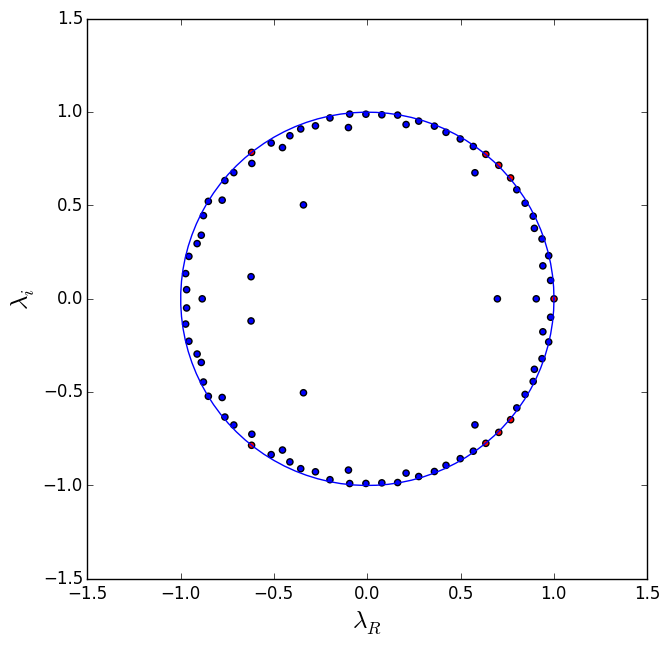

In [71]:
fig = figure(figsize=(8,8))
ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
ax[:scatter](real(λ),imag(λ),c=colors)
ax[:plot](cos(linspace(0,2*pi)),sin(linspace(0,2*pi)))
ylabel("\$\\lambda_i\$",size=18)
xlabel("\$\\lambda_R\$",size=18)
# ylim([-.4,.4])
# savefig("/Users/andyreagan/work/2014/11-foamLab-julia/DMD-eigenvalues-tu-wU.png")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD-eigenvalues-tu-wU.pdf",bbox_inches="tight")

they look identical!

In [8]:
println(size(D))
println(D[1:10,1])

(120000,91)
[314.505,0.000284151,0.015138,310.868,0.000485959,0.0226224,306.496,0.000333538,0.0202265,302.864]


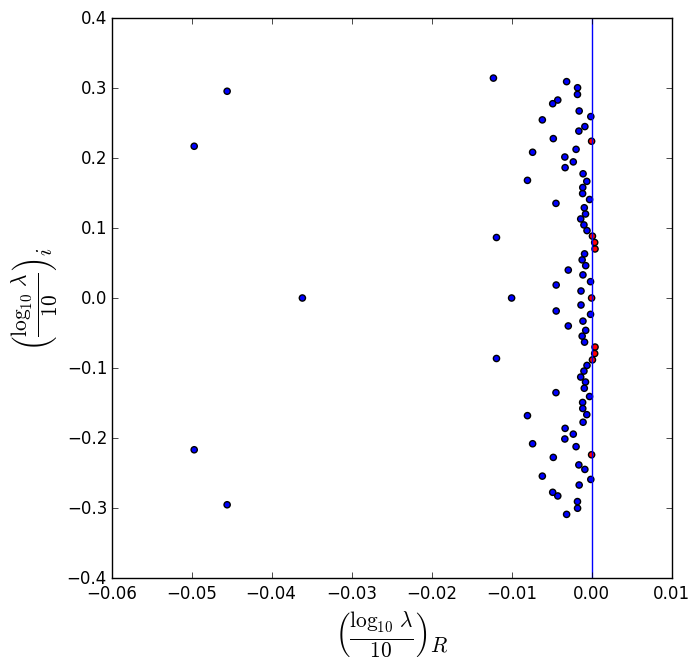

In [77]:
fig = figure(figsize=(8,8))
ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
ax[:scatter](real(log(λ)/10),imag(log(λ)/10),c=colors)
ax[:plot]([0.0,0.0],[-1.0,1.0])
ylabel("\$\\left ( \\frac{\\log _{10} \\, \\lambda }{10} \\right ) _i\$",size=22)
xlabel("\$\\left ( \\frac{\\log _{10} \\, \\lambda }{10} \\right ) _R\$",size=22)
ylim([-.4,.4])
# yticks()
# ax[:set_yticklabels]([])
# savefig("/Users/andyreagan/work/2014/11-foamLab-julia/DMD-eigenvalues-mapped-tu-wU.png")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD-eigenvalues-mapped-tu-wU.pdf",bbox_inches="tight")

mode 2 done
mode 21 done
mode 79 done


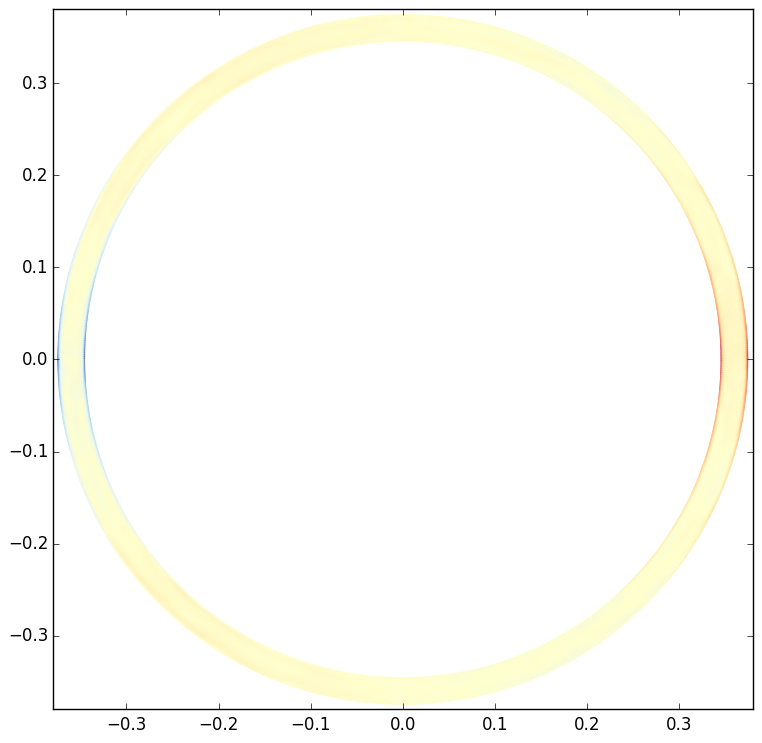

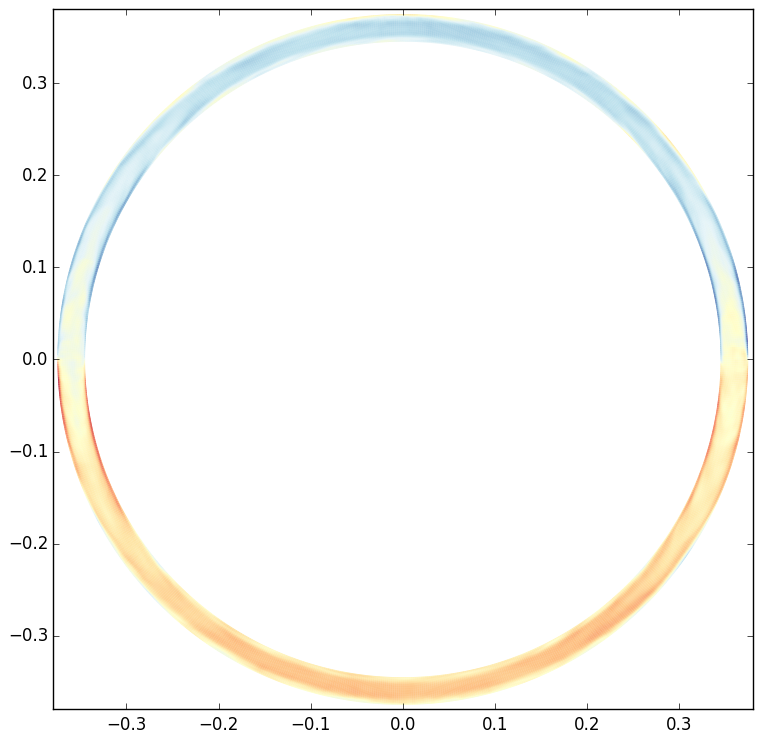

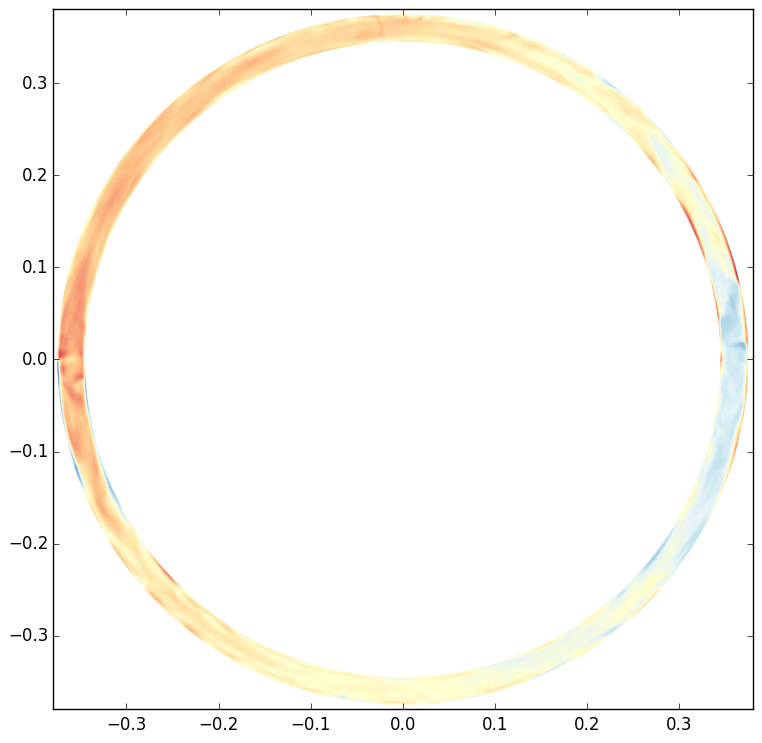

In [49]:
for mode=[2,21,79]
    φ = U*w[:,mode]
    plot_loop_whole_save((real(φ[1:3:end])-minimum(real(φ[1:3:end])))/(maximum(real(φ[1:3:end]))-minimum(real(φ[1:3:end]))),"/Users/andyreagan/work/2014/11-foamLab-julia/DMD-mode$(dec(mode,2))-tu-Wu.png")
    println("mode $(mode) done")
end

In [11]:
mode = 1
φ = U*w[:,mode]

120000-element Array{Complex{Float64},1}:
  -0.00497753+0.0im
  -1.02319e-9+0.0im
    1.7741e-8+0.0im
  -0.00498571+0.0im
  -3.28826e-9+0.0im
   3.44791e-8+0.0im
  -0.00499003+0.0im
  -6.92447e-9+0.0im
   4.06553e-8+0.0im
  -0.00499335+0.0im
  -1.06192e-8+0.0im
   4.17067e-8+0.0im
  -0.00499519+0.0im
             ⋮     
  -0.00494957+0.0im
   6.67322e-9+0.0im
  -1.21777e-9+0.0im
  -0.00492566+0.0im
   3.17189e-9+0.0im
  -8.4367e-10+0.0im
  -0.00488136+0.0im
  9.71058e-10+0.0im
 -3.99215e-10+0.0im
  -0.00481271+0.0im
 -3.96323e-11+0.0im
 -3.18058e-11+0.0im

In [12]:
size(φ)

(120000,)

In [13]:
size(φ[1:3:end])

(40000,)

In [14]:
φ[1:3:15]

5-element Array{Complex{Float64},1}:
 -0.00497753+0.0im
 -0.00498571+0.0im
 -0.00499003+0.0im
 -0.00499335+0.0im
 -0.00499519+0.0im

In [15]:
φ = real(U*w)

120000x90 Array{Float64,2}:
 -0.00497753    0.0538551     0.0538551    …  -0.0122895    -0.0122895  
 -1.02319e-9    3.11014e-7    3.11014e-7      -1.21374e-6   -1.21374e-6 
  1.7741e-8     7.31339e-5    7.31339e-5      -2.72554e-6   -2.72554e-6 
 -0.00498571    0.0365672     0.0365672       -0.0136046    -0.0136046  
 -3.28826e-9    6.83703e-7    6.83703e-7      -2.51856e-6   -2.51856e-6 
  3.44791e-8    0.000143517   0.000143517  …   8.54511e-6    8.54511e-6 
 -0.00499003    0.0230158     0.0230158       -0.00731329   -0.00731329 
 -6.92447e-9    8.59289e-7    8.59289e-7      -3.18755e-7   -3.18755e-7 
  4.06553e-8    0.00016733    0.00016733       2.53896e-5    2.53896e-5 
 -0.00499335    0.0144195     0.0144195        0.000448606   0.000448606
 -1.06192e-8    9.78427e-7    9.78427e-7   …   3.99099e-6    3.99099e-6 
  4.17067e-8    0.000167373   0.000167373      4.23615e-5    4.23615e-5 
 -0.00499519    0.00929972    0.00929972       0.00604888    0.00604888 
  ⋮                    

In [16]:
# load a snapshot
t = 1276
T = readVar(baseCase,stringG(t),"T")
Uv = readVar(baseCase,stringG(t),"U")
Uv[1,:] = T[1,:]
snapshot = reshape(Uv[1:3,:],120000)
println(size(snapshot))
println(size(φ))
# project it onto the DMD modes
projection = pinv(φ' * φ) * φ' * snapshot
println(projection)
size(projection)


(120000,)
(120000,90)
[-60923.02279288889,-65.95548409473817,-65.95548409476454,62.41124799047351,62.41124799047106,62.71368253590244,5.273791608852468,5.27379160885407,27.901542384087076,27.901542384117885,-6.423889789011573,-6.423889789038075,-27.095726094149178,-27.09572609420259,56.38557789356279,56.3855778935365,50.67293288889604,50.67293288885372,-23.450625187095614,-23.450625187079503,-8.263203417067833,-8.263203417063767,-78.59973938653066,-13.919405085749009,-13.919405085741484,-1.769195257755112,-1.769195257758401,11.744754068750959,11.744754068771362,14.200788377316366,14.200788377315142,5.207281783470443,5.207281783469532,8.576618280471648,8.576618280468017,21.65154053113073,21.651540531138853,15.930589708949947,15.930589708962438,-34.609555467661245,-30.241402302192018,-30.241402302188472,-3.3328687002851076,-3.3328687002446036,21.723976000329973,21.72397600034208,2.231327264041871,2.23132726404219,-32.237535768719006,-32.237535768719006,-30.377035594770508,-30.37703559477

(90,)

In [17]:
# look at the dmd mode projection for all states (average the coeffs)

# from long-timeseries-plot notebook
reversal_times = [161.0,209.0,269.0,425.0,747.0,991.0,1077.0,1317.0,1389.0,1465.0,1537.0,1627.0,1705.0,1767.0,1927.0,2005.0,2159.0,2563.0,2809.0,2975.0,3057.0,3123.0,3207.0,3283.0,3359.0,3433.0,3505.0,3575.0,3661.0,3753.0,3919.0,3983.0,4157.0,4229.0,4483.0,4551.0,4623.0,4781.0,4943.0]

longer_times = 100:2:5000
all_projects = zeros(length(longer_times),90)
# now load them all
# println(size(reversal_times))
# D = zeros(120000,size(times)[1])
total_coeffs = zeros(90)
total_coeffs_abs = zeros(90)
for time=1:size(longer_times)[1]
    t = longer_times[time]
    println(t)
    T = readVar(baseCase,stringG(t),"T")
    Uv = readVar(baseCase,stringG(t),"U")
    Uv[1,:] = T[1,:]
    snapshot = reshape(Uv[1:3,:],120000)
    # project it onto the DMD modes
    projection = pinv(φ' * φ) * φ' * snapshot
    total_coeffs = total_coeffs + projection
    total_coeffs_abs = total_coeffs_abs + abs(projection)
    all_projects[time,:] = projection
end

100
102
104
106
108
110
112
114
116
118
120
122
124
126
128
130
132
134
136
138
140
142
144
146
148
150
152
154
156
158
160
162
164
166
168
170
172
174
176
178
180
182
184
186
188
190
192
194
196
198
200
202
204
206
208
210
212
214
216
218
220
222
224
226
228
230
232
234
236
238
240
242
244
246
248
250
252
254
256
258
260
262
264
266
268
270
272
274
276
278
280
282
284
286
288
290
292
294
296
298
300
302
304
306
308
310
312
314
316
318
320
322
324
326
328
330
332
334
336
338
340
342
344
346
348
350
352
354
356
358
360
362
364
366
368
370
372
374
376
378
380
382
384
386
388
390
392
394
396
398
400
402
404
406
408
410
412
414
416
418
420
422
424
426
428
430
432
434
436
438
440
442
444
446
448
450
452
454
456
458
460
462
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
522
524
526
528
530
532
534
536
538
540
542
544
546
548
550
552
554
556
558
560
562
564
566
568
570
572
574
576
578
580
582
584
586
588
590
592
594
596
598


In [50]:
# check that faces and cells are loaded into scope
faces

4-element Array{Array{Int64,1},1}:
 [19713,19715,19717,19719,19721,19723,19725,19727,19729,19731  …  19773,19775,19777,19779,19781,19783,19785,19787,19789,19790]
 [39543,39546,39549,39552,39555,39558,39561,39564,39567,39570  …  39633,39636,39639,39642,39645,39648,39651,39654,39657,39659]
 [39463,39465,39467,39469,39471,39473,39475,39477,39479,39481  …  39523,39525,39527,39529,39531,39533,39535,39537,39539,39540]
 [3,6,9,12,15,18,21,24,27,30  …  93,96,99,102,105,108,111,114,117,119]                                                        

In [54]:
cells

4-element Array{Array{Int64,1},1}:
 [9961,9962,9963,9964,9965,9966,9967,9968,9969,9970  …  9991,9992,9993,9994,9995,9996,9997,9998,9999,10000]                   
 [20001,20002,20003,20004,20005,20006,20007,20008,20009,20010  …  20031,20032,20033,20034,20035,20036,20037,20038,20039,20040]
 [19961,19962,19963,19964,19965,19966,19967,19968,19969,19970  …  19991,19992,19993,19994,19995,19996,19997,19998,19999,20000]
 [1,2,3,4,5,6,7,8,9,10  …  31,32,33,34,35,36,37,38,39,40]                                                                     

In [56]:
include("/Users/andyreagan/work/2014/11-foamLab-julia/ensembleFunctions.jl")

compute_shift (generic function with 1 method)

In [58]:
stringG(10)

"10"

In [60]:
all_flux_timeseries = zeros(length(longer_times))
for time=1:size(longer_times)[1]
    t = longer_times[time]
    println(t)
    flux = readFlux(baseCase,t,faces)
    all_flux_timeseries[time] = flux
end

100
the flux at time 100 is -1.437369495e-10
102
the flux at time 102 is -1.8147527749999998e-10
104
the flux at time 104 is -2.3126651e-10
106
the flux at time 106 is -2.9559586500000003e-10
108
the flux at time 108 is -3.7796250750000006e-10
110
the flux at time 110 is -4.805405225000001e-10
112
the flux at time 112 is -6.134113449999999e-10
114
the flux at time 114 is -7.897217599999999e-10
116
the flux at time 116 is -1.02478545e-9
118
the flux at time 118 is -1.3346466e-9
120
the flux at time 120 is -1.7360592e-9
122
the flux at time 122 is -2.24816745e-9
124
the flux at time 124 is -2.902811e-9
126
the flux at time 126 is -3.7252414499999995e-9
128
the flux at time 128 is -4.72947745e-9
130
the flux at time 130 is -5.9082043e-9
132
the flux at time 132 is -7.2172613749999996e-9
134
the flux at time 134 is -8.5600911e-9
136
the flux at time 136 is -9.78393355e-9
138
the flux at time 138 is -1.06912529e-8
140
the flux at time 140 is -1.1105371e-8
142
the flux at time 142 is -1.0927

In [18]:
total_coeffs

90-element Array{Float64,1}:
      -1.49405e8
  -55580.4      
  -55580.4      
   -6643.6      
   -6643.6      
 -242853.0      
    -291.839    
    -291.839    
   -4859.57     
   -4859.57     
    8548.64     
    8548.64     
  -12773.0      
       ⋮        
    1416.53     
    1416.53     
     921.391    
     921.391    
    2771.65     
    2771.65     
  -15211.6      
  -15211.6      
    5004.12     
    5004.12     
  -22734.7      
  -22734.7      

In [19]:
total_coeffs_abs

90-element Array{Float64,1}:
      1.49405e8
 253766.0      
 253766.0      
  59164.4      
  59164.4      
 385995.0      
  89212.6      
  89212.6      
  48674.7      
  48674.7      
  80432.7      
  80432.7      
  71379.7      
      ⋮        
 105160.0      
 105160.0      
  37464.6      
  37464.6      
  53142.4      
  53142.4      
 158192.0      
 158192.0      
  55709.7      
  55709.7      
  99410.3      
  99410.3      

In [20]:
total_coeffs_prereversal_1 = zeros(90)
total_coeffs_abs_prereversal_1 = zeros(90)
for time=1:size(reversal_times)[1]
    t = reversal_times[time]-1
    println(t)
    T = readVar(baseCase,stringG(t),"T")
    Uv = readVar(baseCase,stringG(t),"U")
    Uv[1,:] = T[1,:]
    snapshot = reshape(Uv[1:3,:],120000)
    # project it onto the DMD modes
    projection = pinv(φ' * φ) * φ' * snapshot
    total_coeffs_prereversal_1 = total_coeffs_prereversal_1 + projection
    total_coeffs_abs_prereversal_1 = total_coeffs_abs_prereversal_1 + abs(projection)
end

160.0
208.0
268.0
424.0
746.0
990.0
1076.0
1316.0
1388.0
1464.0
1536.0
1626.0
1704.0
1766.0
1926.0
2004.0
2158.0
2562.0
2808.0
2974.0
3056.0
3122.0
3206.0
3282.0
3358.0
3432.0
3504.0
3574.0
3660.0
3752.0
3918.0
3982.0
4156.0
4228.0
4482.0
4550.0
4622.0
4780.0
4942.0


In [21]:
total_coeffs_prereversal_2 = zeros(90)
total_coeffs_abs_prereversal_2 = zeros(90)
for time=1:size(reversal_times)[1]
    t = reversal_times[time]-3
    println(t)
    T = readVar(baseCase,stringG(t),"T")
    Uv = readVar(baseCase,stringG(t),"U")
    Uv[1,:] = T[1,:]
    snapshot = reshape(Uv[1:3,:],120000)
    # project it onto the DMD modes
    projection = pinv(φ' * φ) * φ' * snapshot
    total_coeffs_prereversal_2 = total_coeffs_prereversal_2 + projection
    total_coeffs_abs_prereversal_2 = total_coeffs_abs_prereversal_2 + abs(projection)
end

158.0
206.0
266.0
422.0
744.0
988.0
1074.0
1314.0
1386.0
1462.0
1534.0
1624.0
1702.0
1764.0
1924.0
2002.0
2156.0
2560.0
2806.0
2972.0
3054.0
3120.0
3204.0
3280.0
3356.0
3430.0
3502.0
3572.0
3658.0
3750.0
3916.0
3980.0
4154.0
4226.0
4480.0
4548.0
4620.0
4778.0
4940.0


In [22]:
total_coeffs_prereversal_3 = zeros(90)
total_coeffs_abs_prereversal_3 = zeros(90)
for time=1:size(reversal_times)[1]
    t = reversal_times[time]-5
    println(t)
    T = readVar(baseCase,stringG(t),"T")
    Uv = readVar(baseCase,stringG(t),"U")
    Uv[1,:] = T[1,:]
    snapshot = reshape(Uv[1:3,:],120000)
    # project it onto the DMD modes
    projection = pinv(φ' * φ) * φ' * snapshot
    total_coeffs_prereversal_3 = total_coeffs_prereversal_3 + projection
    total_coeffs_abs_prereversal_3 = total_coeffs_abs_prereversal_3 + abs(projection)
end

156.0
204.0
264.0
420.0
742.0
986.0
1072.0
1312.0
1384.0
1460.0
1532.0
1622.0
1700.0
1762.0
1922.0
2000.0
2154.0
2558.0
2804.0
2970.0
3052.0
3118.0
3202.0
3278.0
3354.0
3428.0
3500.0
3570.0
3656.0
3748.0
3914.0
3978.0
4152.0
4224.0
4478.0
4546.0
4618.0
4776.0
4938.0


In [23]:
total_coeffs_prereversal_4 = zeros(90)
total_coeffs_abs_prereversal_4 = zeros(90)
for time=1:size(reversal_times)[1]
    t = reversal_times[time]-7
    println(t)
    T = readVar(baseCase,stringG(t),"T")
    Uv = readVar(baseCase,stringG(t),"U")
    Uv[1,:] = T[1,:]
    snapshot = reshape(Uv[1:3,:],120000)
    # project it onto the DMD modes
    projection = pinv(φ' * φ) * φ' * snapshot
    total_coeffs_prereversal_4 = total_coeffs_prereversal_4 + projection
    total_coeffs_abs_prereversal_4 = total_coeffs_abs_prereversal_4 + abs(projection)
end

154.0
202.0
262.0
418.0
740.0
984.0
1070.0
1310.0
1382.0
1458.0
1530.0
1620.0
1698.0
1760.0
1920.0
1998.0
2152.0
2556.0
2802.0
2968.0
3050.0
3116.0
3200.0
3276.0
3352.0
3426.0
3498.0
3568.0
3654.0
3746.0
3912.0
3976.0
4150.0
4222.0
4476.0
4544.0
4616.0
4774.0
4936.0


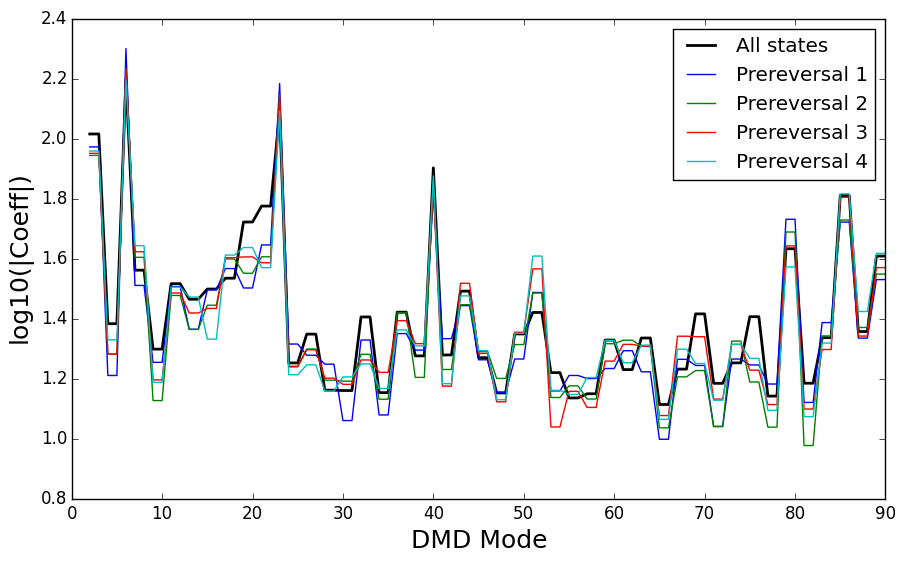

In [24]:
figure(figsize=(10.5,6))
plot(2:length(total_coeffs_abs),log10(total_coeffs_abs[2:end]/length(longer_times)),"k",label="All states",linewidth=2)
plot(2:length(total_coeffs_abs),log10(total_coeffs_abs_prereversal_1[2:end]/length(reversal_times)),label="Prereversal 1")
plot(2:length(total_coeffs_abs),log10(total_coeffs_abs_prereversal_2[2:end]/length(reversal_times)),label="Prereversal 2")
plot(2:length(total_coeffs_abs),log10(total_coeffs_abs_prereversal_3[2:end]/length(reversal_times)),label="Prereversal 3")
plot(2:length(total_coeffs_abs),log10(total_coeffs_abs_prereversal_4[2:end]/length(reversal_times)),label="Prereversal 4")
ylabel("log10(|Coeff|)",size=18)
xlabel("DMD Mode",size=18)
legend(loc="best")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/DMD_modes_pre_reversals.png",bbox_inches="tight")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/DMD_modes_pre_reversals.pdf",bbox_inches="tight")

In [25]:
all_projects

2451x90 Array{Float64,2}:
 -60481.7  -291.719    -291.719    …    8.40533   -174.466    -174.466  
 -60481.9  -280.059    -280.059        11.6488    -175.802    -175.802  
 -60476.0  -268.791    -268.791         6.94065   -180.3      -180.3    
 -60474.5  -259.886    -259.886         9.02065   -165.009    -165.009  
 -60490.5  -267.692    -267.692         7.77476   -181.242    -181.242  
 -60510.8  -250.369    -250.369    …  -16.3953    -213.048    -213.048  
 -60488.1  -212.433    -212.433        -9.09151   -201.453    -201.453  
 -60484.3  -206.488    -206.488         0.406288  -155.143    -155.143  
 -60473.3  -155.456    -155.456       -12.6844    -169.754    -169.754  
 -60428.5   -91.2436    -91.2436        5.96236   -168.871    -168.871  
 -60466.3   -84.6834    -84.6834   …  -28.4138    -153.532    -153.532  
 -60404.2     4.1215      4.1215      -27.0058     -96.1051    -96.1051 
 -60342.9    77.4984     77.4984       -3.88042    -79.1228    -79.1228 
      ⋮                  

In [26]:
help(sum)

Base.sum(itr)

   Returns the sum of all elements in a collection.

Base.sum(A, dims)

   Sum elements of an array over the given dimensions.

Base.sum(f, itr)

   Sum the results of calling function "f" on each element of
   "itr".


In [27]:
# should be zero...?
squeeze(sum(all_projects,1),1)-total_coeffs

90-element Array{Float64,1}:
 -2.08616e-7 
 -1.67347e-10
  1.45519e-11
 -3.63798e-12
  6.36646e-12
 -2.91038e-11
  5.22959e-12
  1.13687e-12
 -1.81899e-12
  7.27596e-12
 -1.81899e-12
  0.0        
  1.09139e-11
  ⋮          
 -2.27374e-13
 -2.27374e-13
  2.6148e-12 
  2.6148e-12 
 -4.54747e-13
 -4.54747e-13
 -5.45697e-12
 -5.45697e-12
 -9.09495e-13
  1.36424e-11
  2.54659e-11
  2.54659e-11

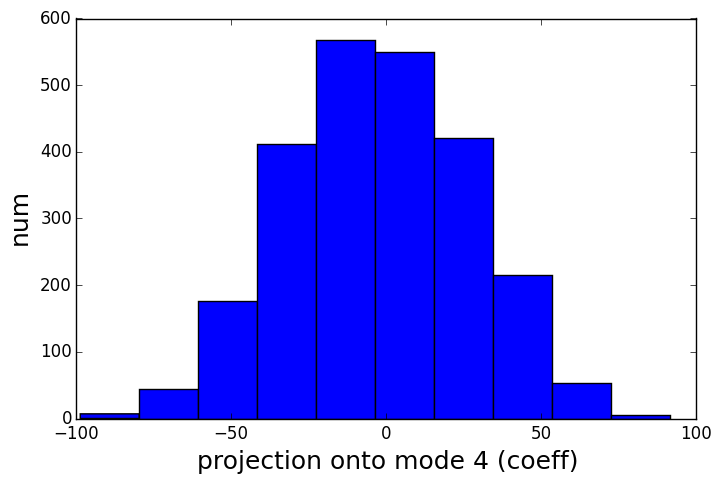

In [28]:
# modes 4 and 5 looked good. let's look at the distribution of projections
function plot_mode_histogram(mode)
    # mode = 4
    figure(figsize=(8,5))
    plt.hist(all_projects[:,mode])
    ylabel("num",size=18)
    xlabel("projection onto mode $(mode) (coeff)",size=18)
    # legend(loc="best")
    savefig("/Users/andyreagan/work/2014/11-foamLab-julia/DMD_mode_$(mode)_projection_hist.png")
end
plot_mode_histogram(4)

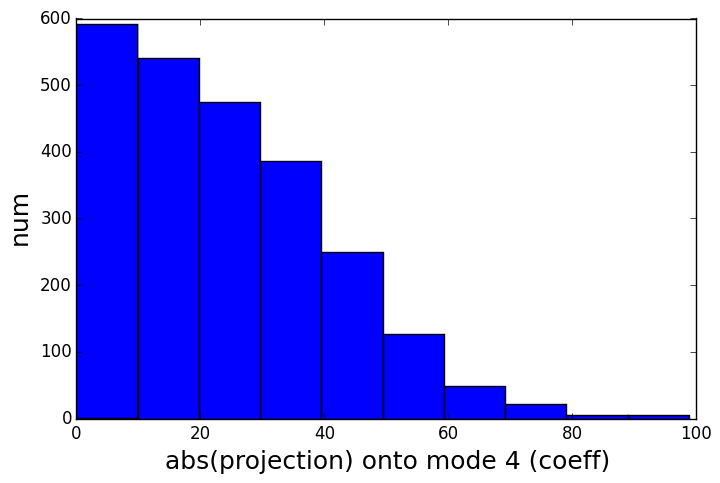

In [29]:
function plot_mode_histogram_abs(mode)
    # mode = 4
    figure(figsize=(8,5))
    plt.hist(abs(all_projects[:,mode]))
    ylabel("num",size=18)
    xlabel("abs(projection) onto mode $(mode) (coeff)",size=18)
    # legend(loc="best")
    savefig("/Users/andyreagan/work/2014/11-foamLab-julia/DMD_mode_$(mode)_projection_hist_abs.png")
end
plot_mode_histogram_abs(4)

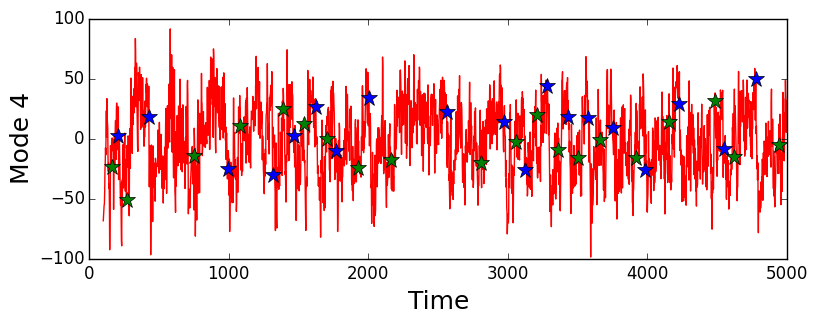

In [42]:
# modes 4 and 5 looked good. let's look at the distribution of projections
function plot_mode_timeseries(mode)
    figure(figsize=(9,3))
    # mode = 4
    plot(longer_times,all_projects[:,mode],"r")
    for i=1:length(reversal_times)
        if mod(i,2) == 0
            plot(reversal_times[i],all_projects[:,mode][(reversal_times[i]-101)/2],"*",markersize=12,color="b",label="CW")
        else
            plot(reversal_times[i],all_projects[:,mode][(reversal_times[i]-101)/2],"*",markersize=12,color="g",label="CCW")
        end
    end
    # plot(reversal_times,all_projects[:,mode][(reversal_times-101)/2],"*",markersize=15)
    ylabel("Mode $(mode)",size=18)
    xlabel("Time",size=18)
    # legend(loc="best")
    savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD_mode_$(mode)_projection_timeseries.png",bbox_inches="tight")
    savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD_mode_$(mode)_projection_timeseries.pdf",bbox_inches="tight")
end
plot_mode_timeseries(4)

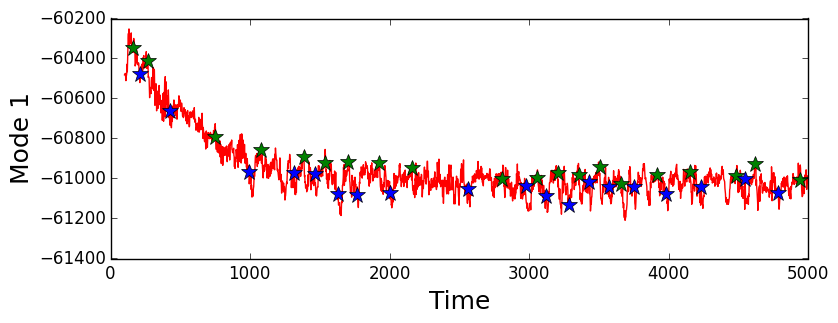

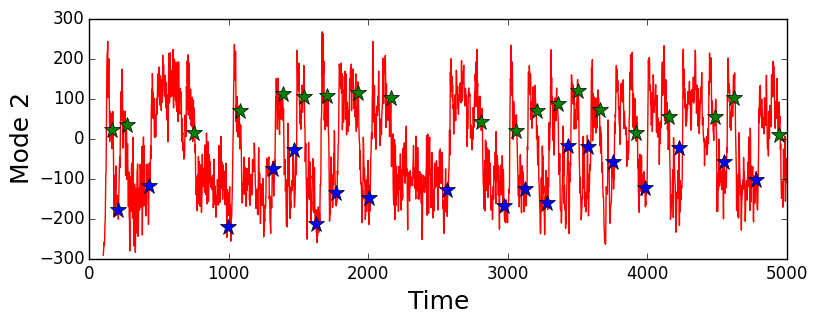

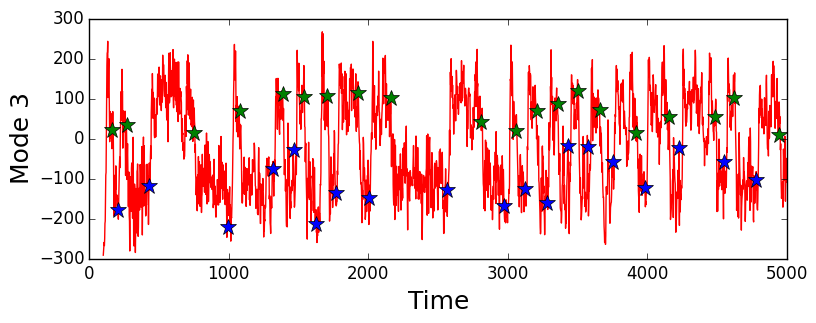

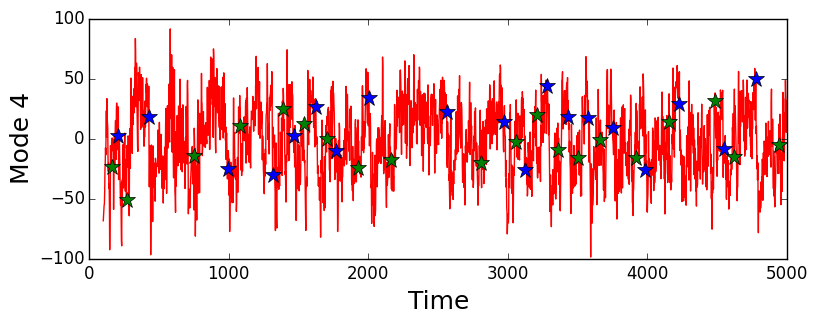

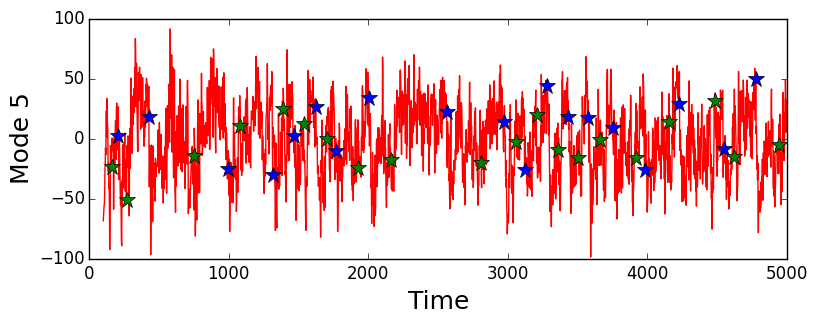

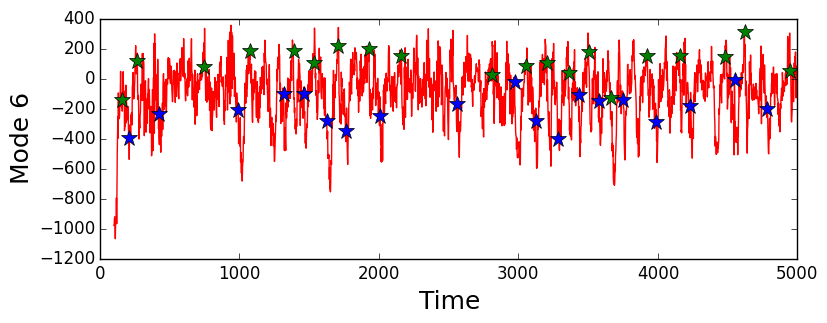

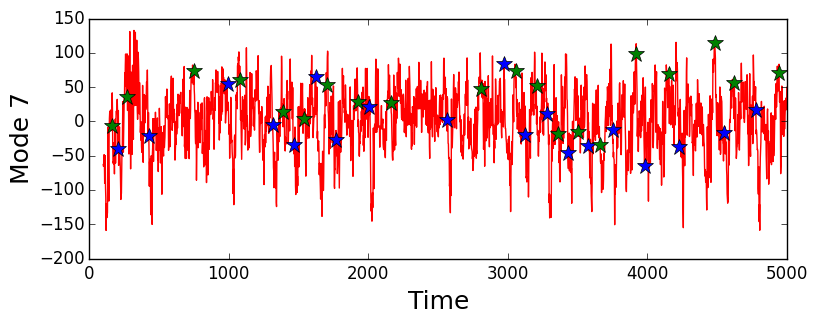

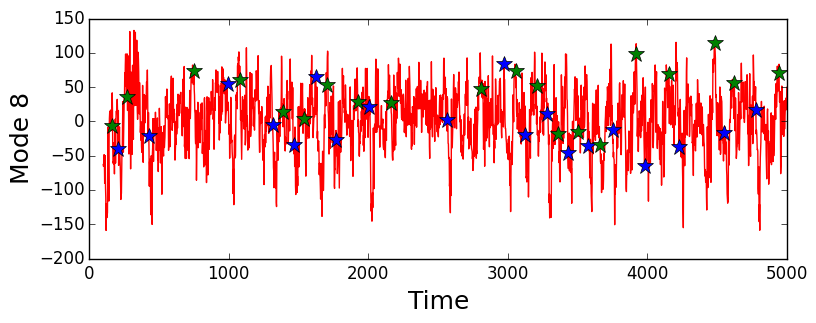

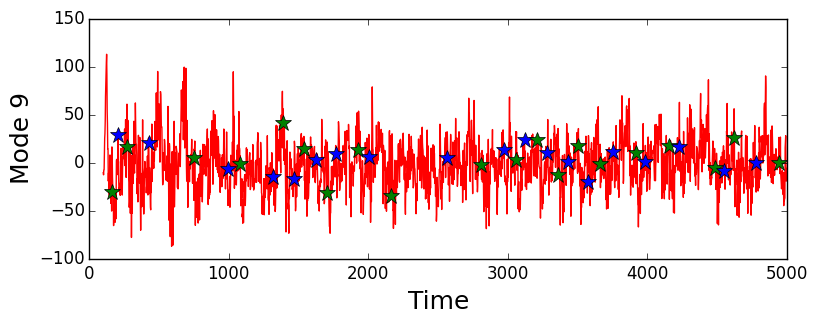

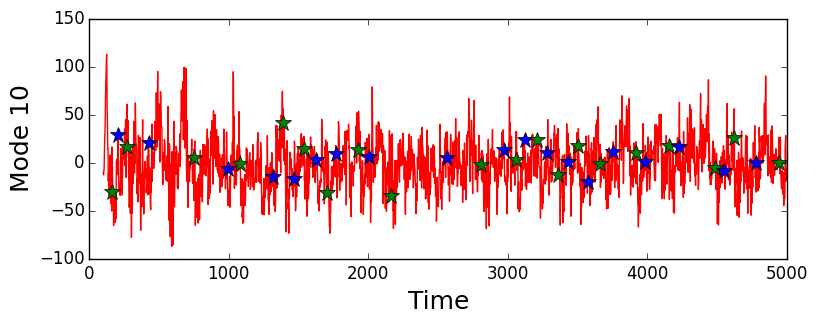

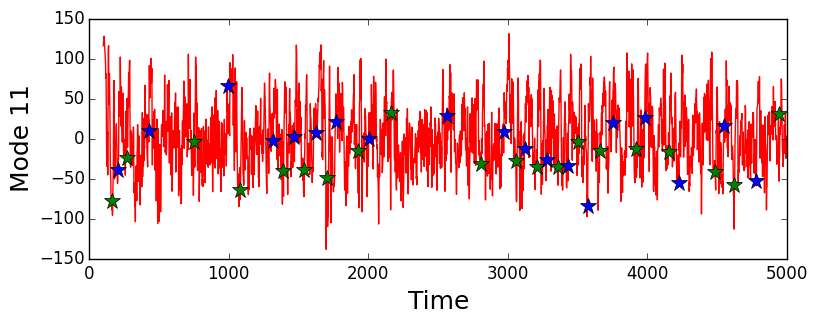

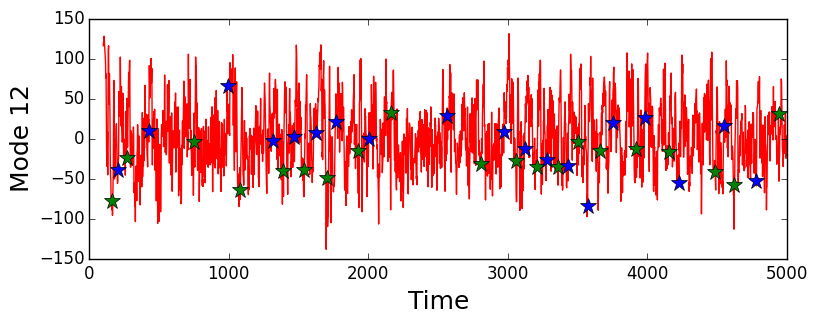

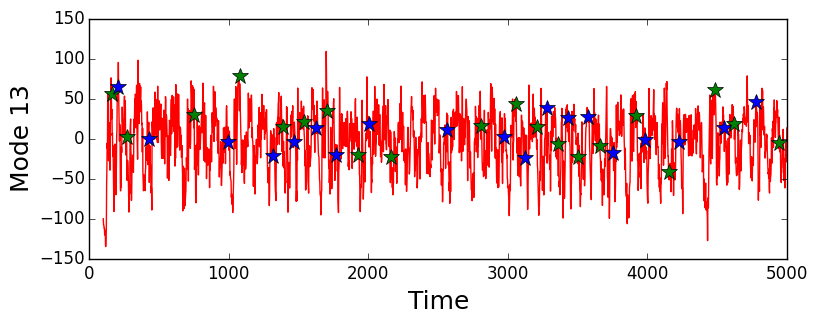

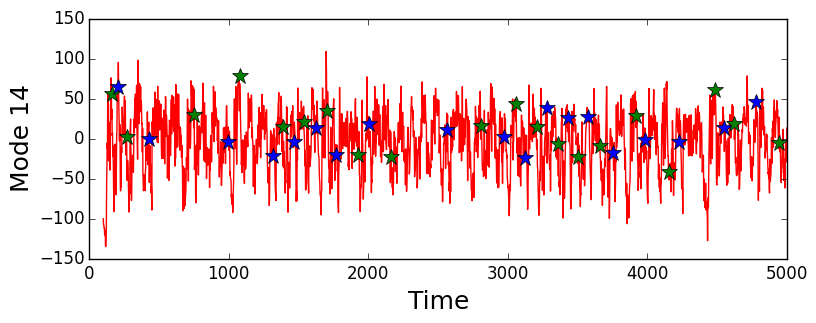

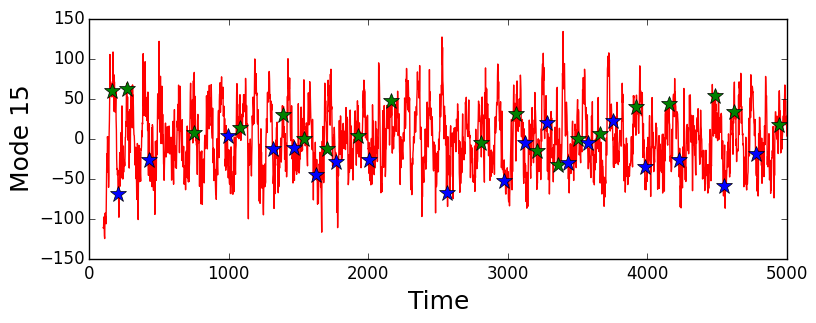

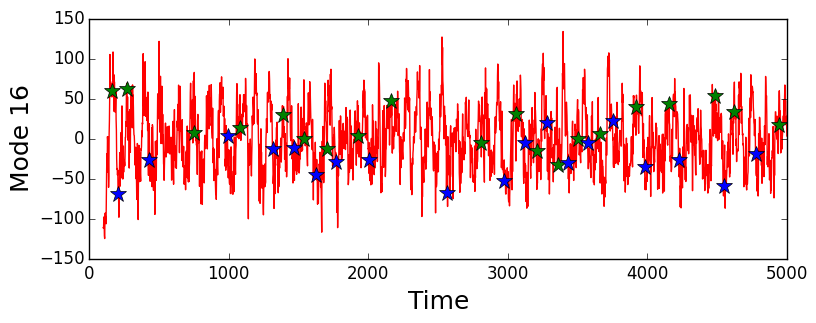

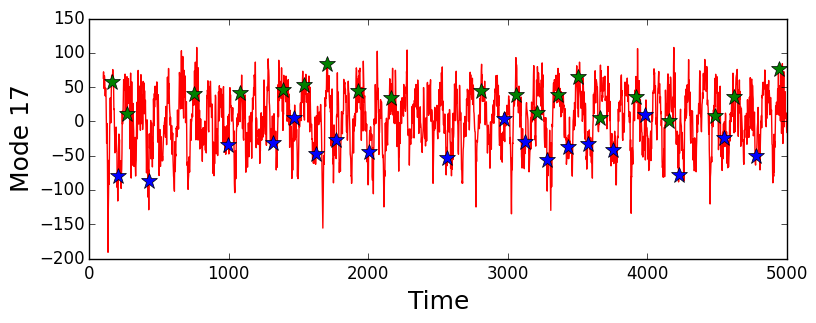

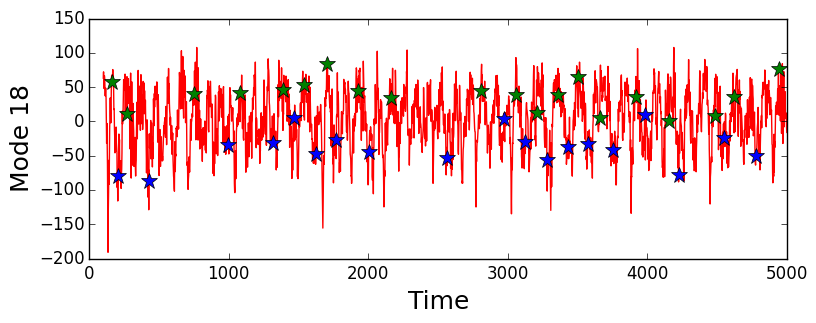

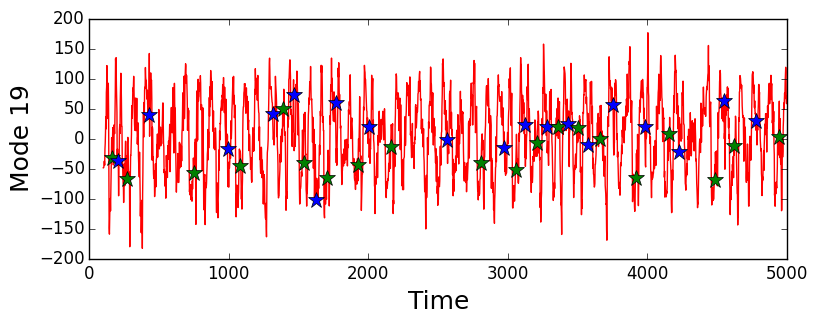

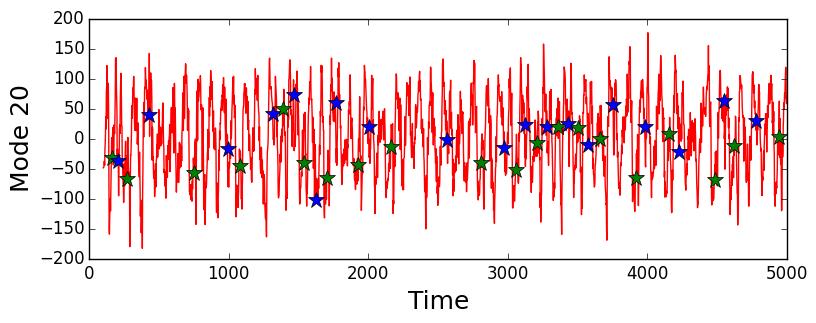

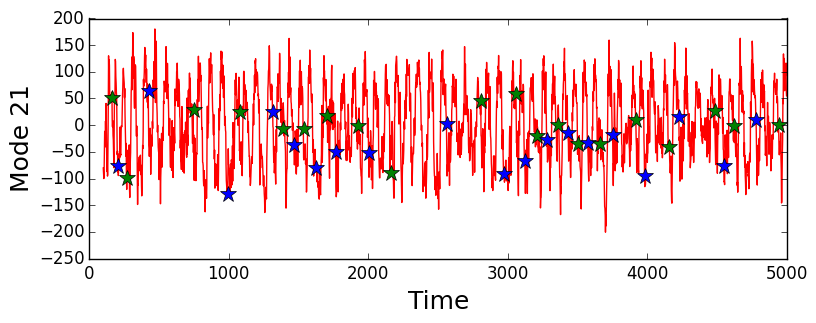

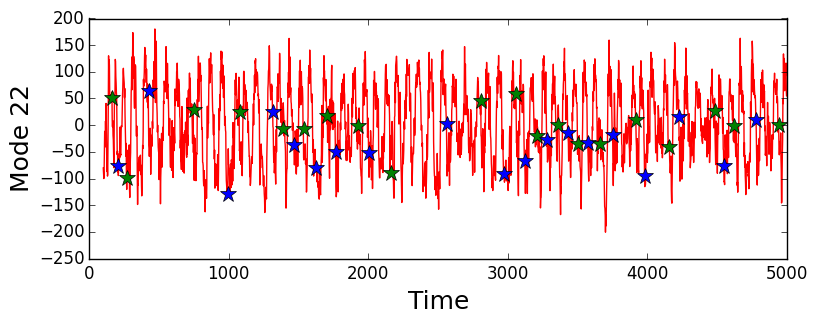

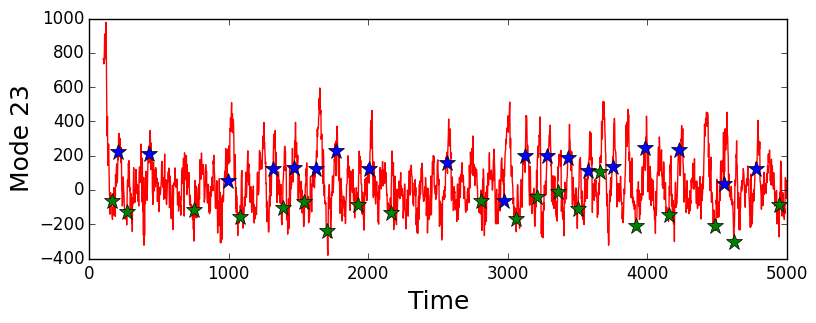

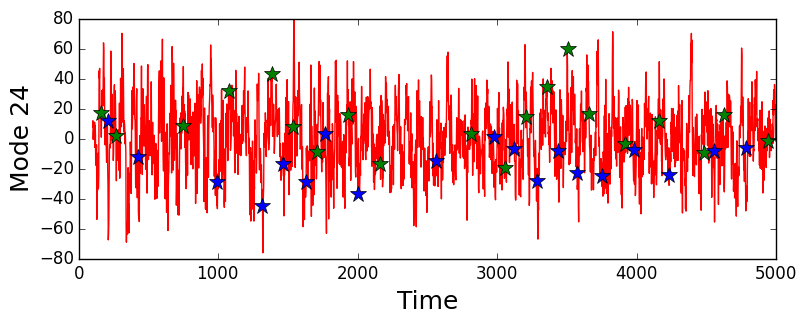

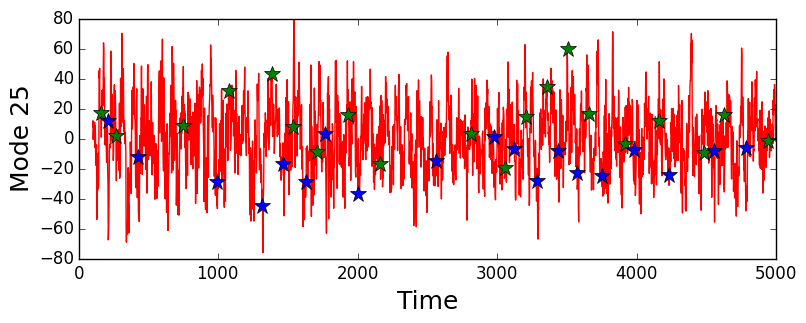

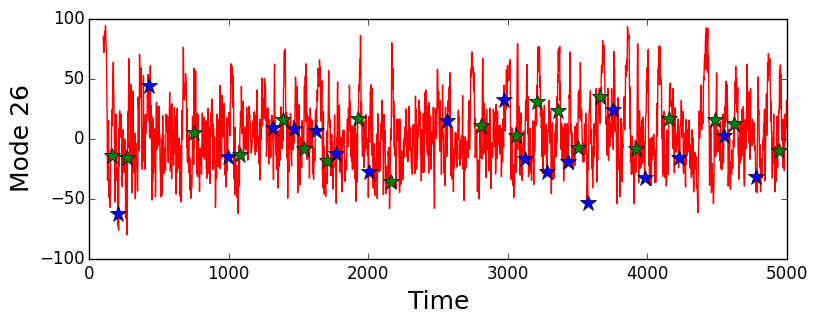

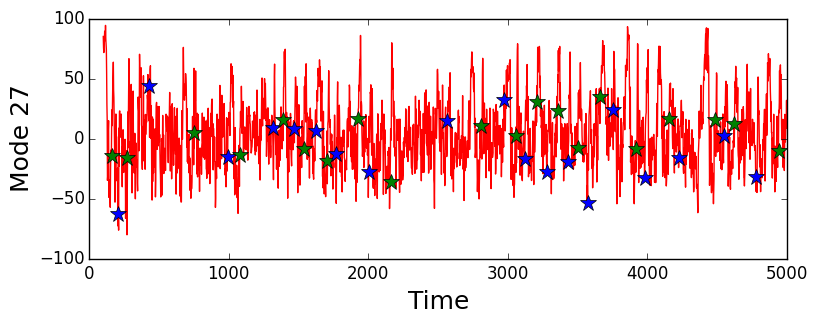

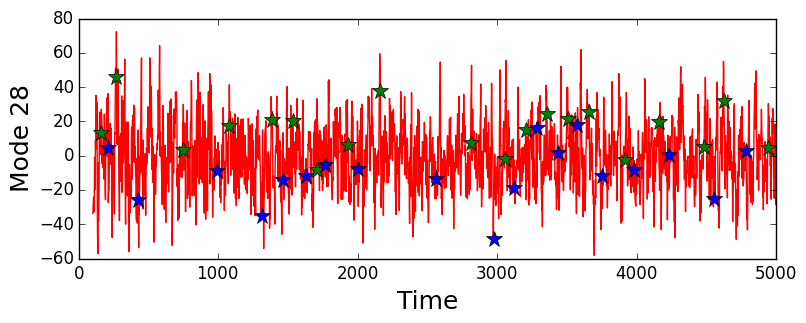

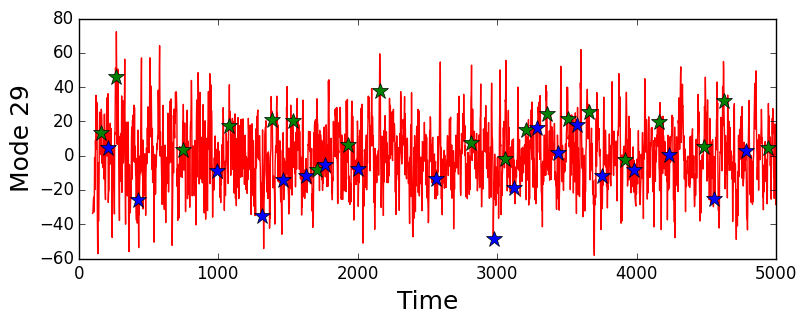

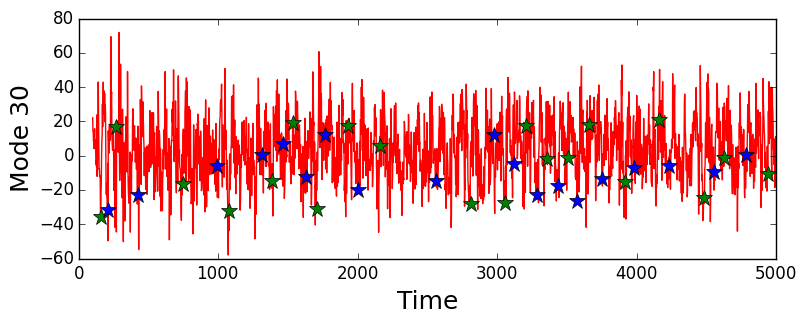

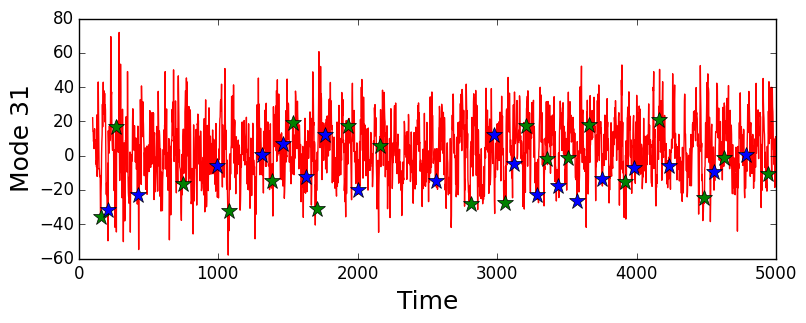

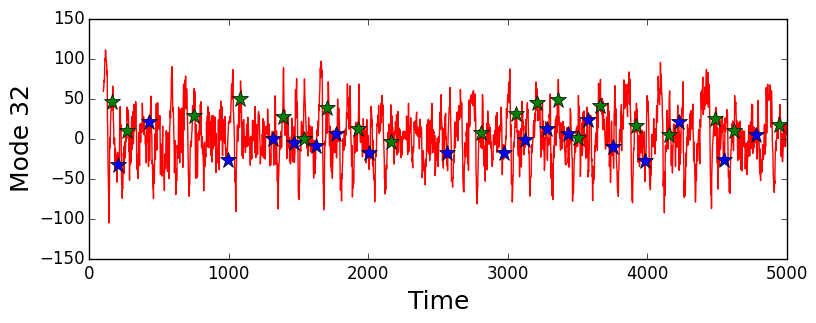

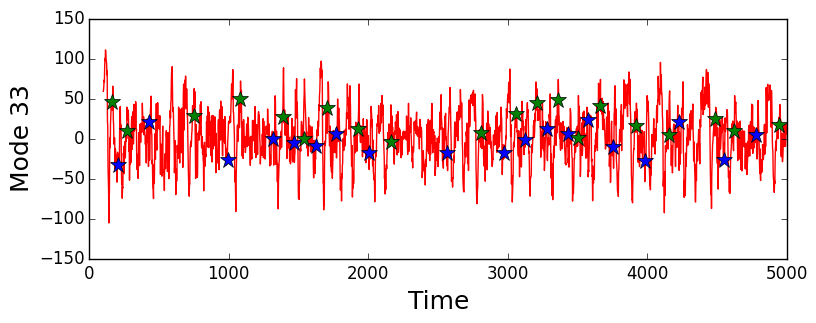

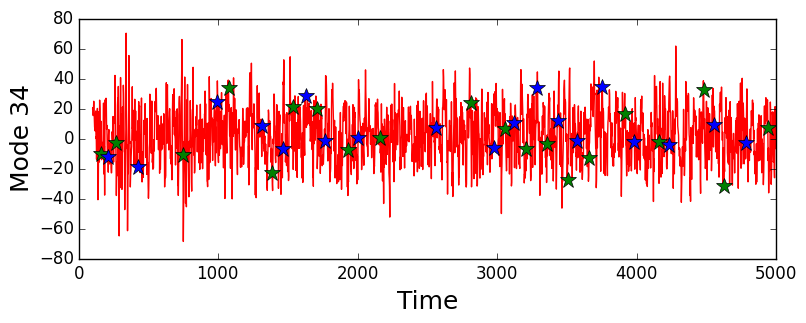

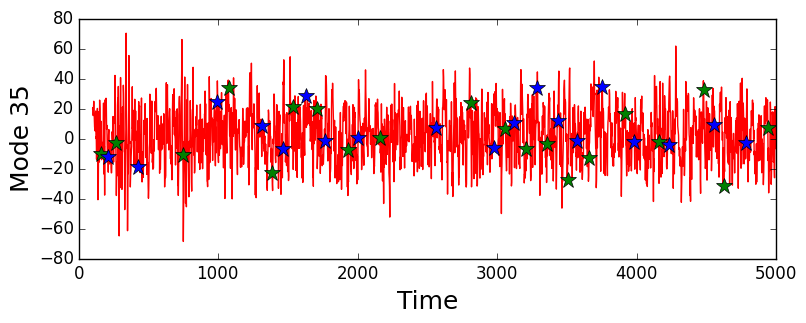

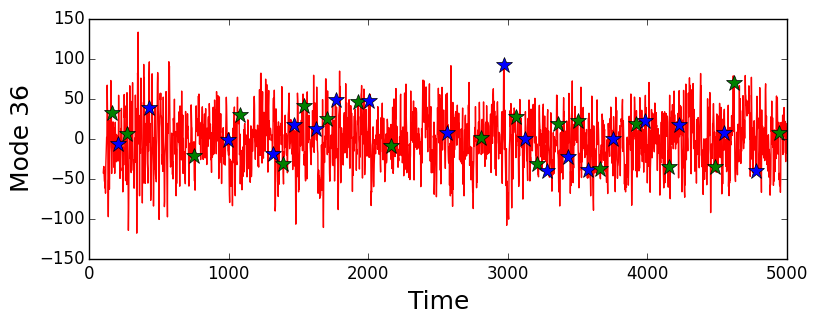

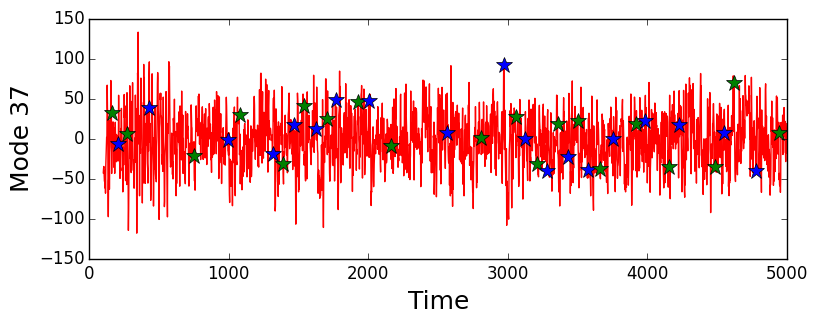

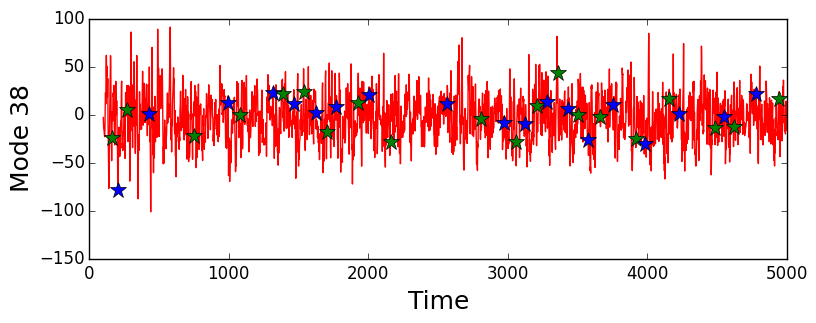

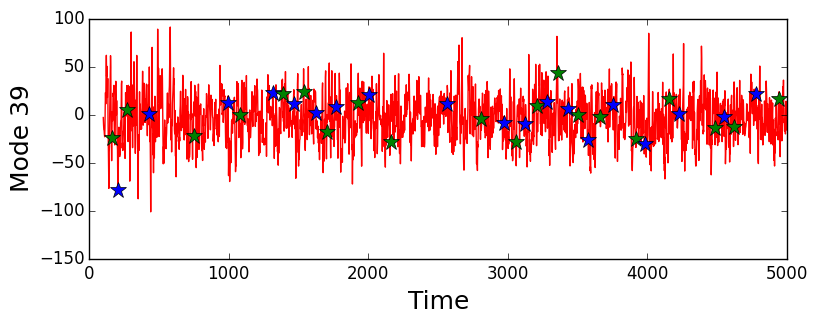

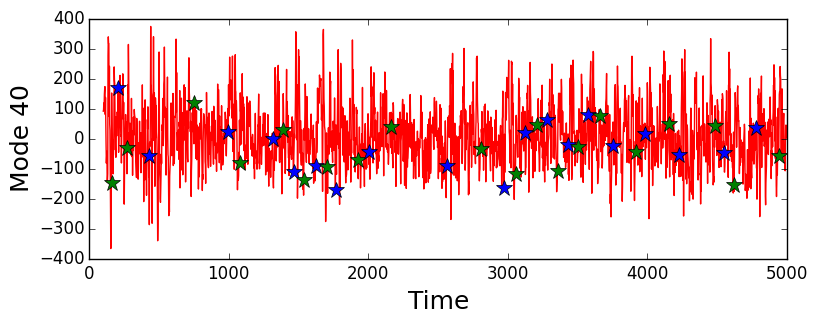

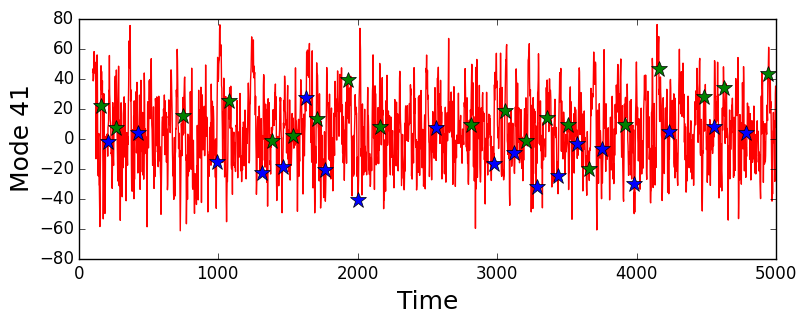

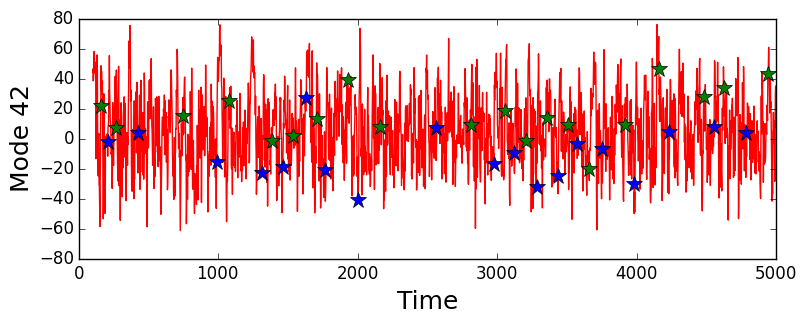

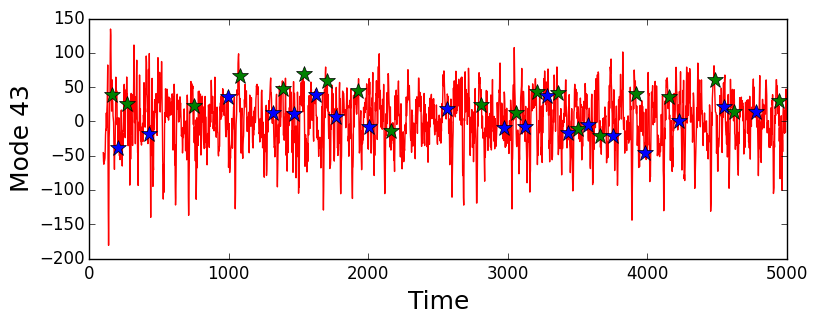

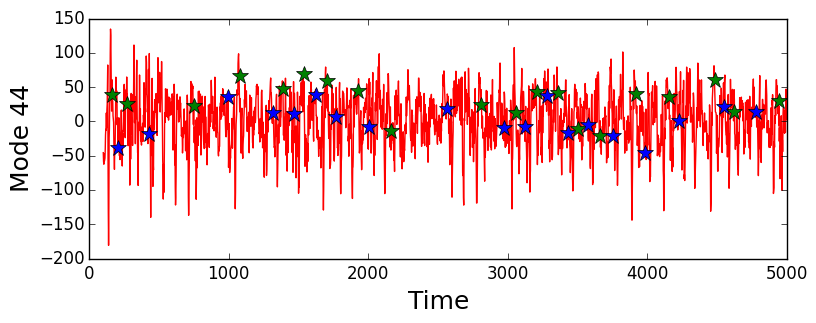

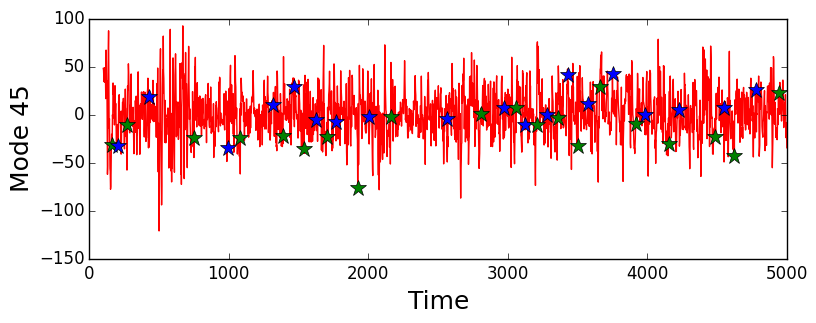

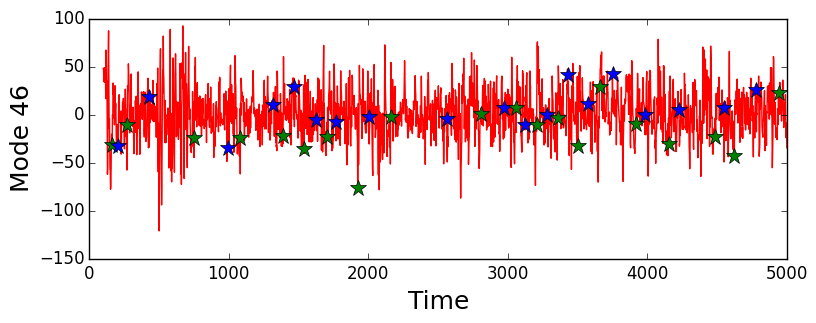

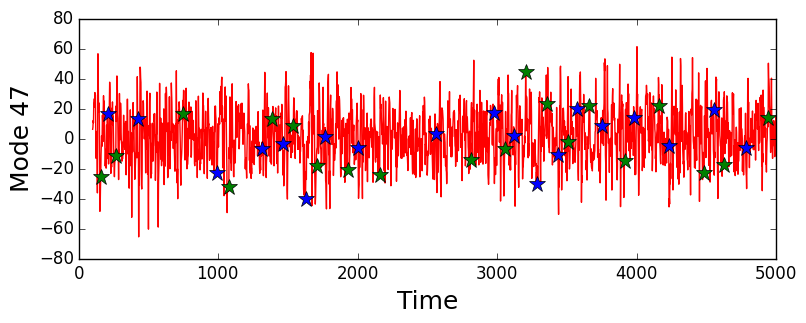

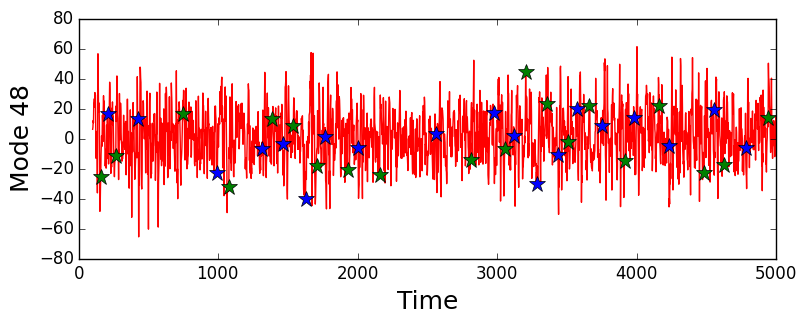

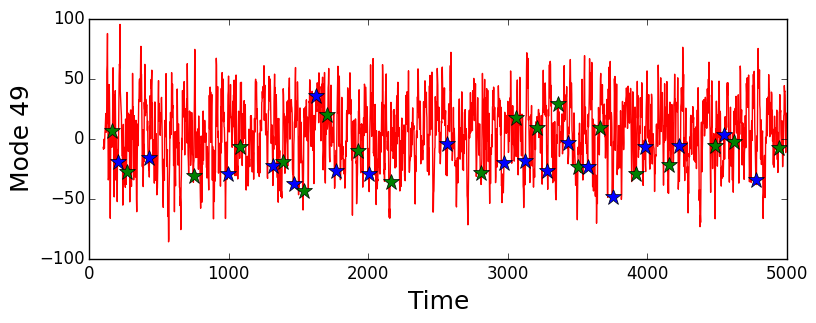

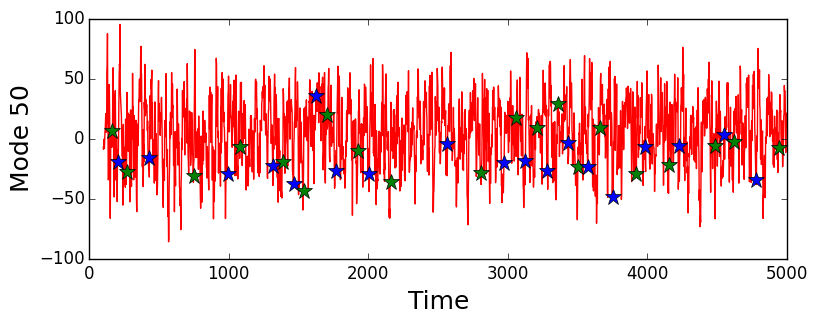

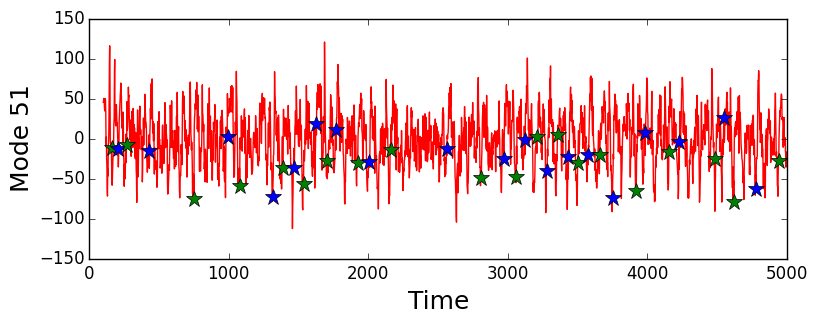

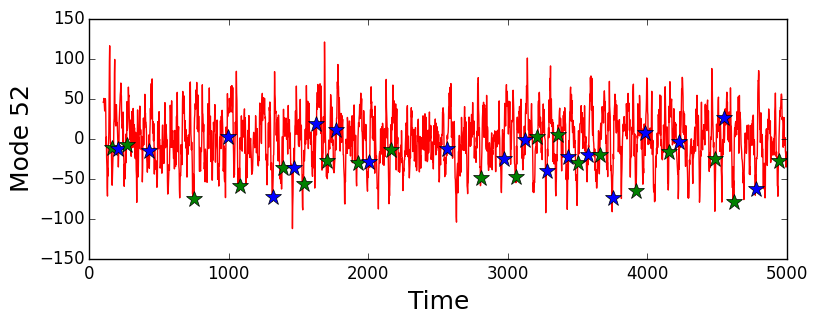

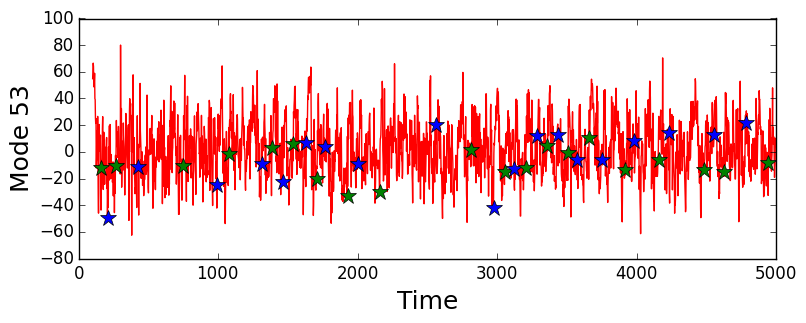

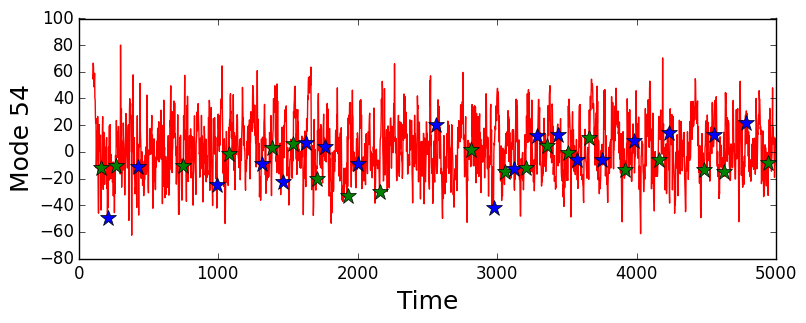

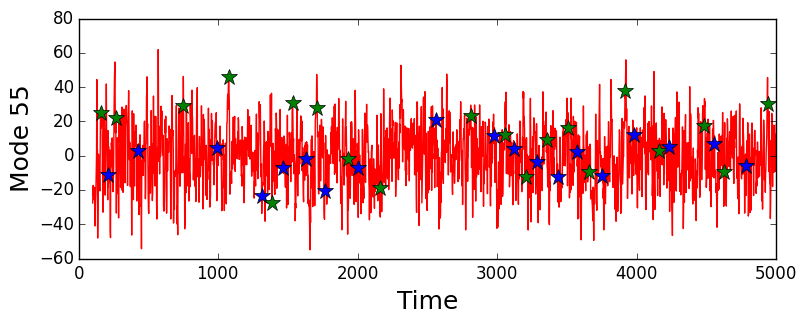

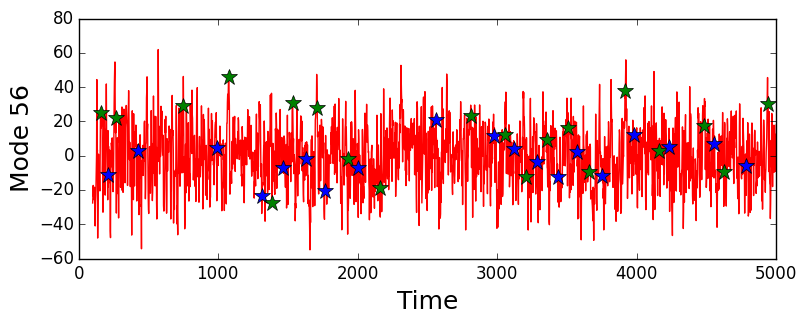

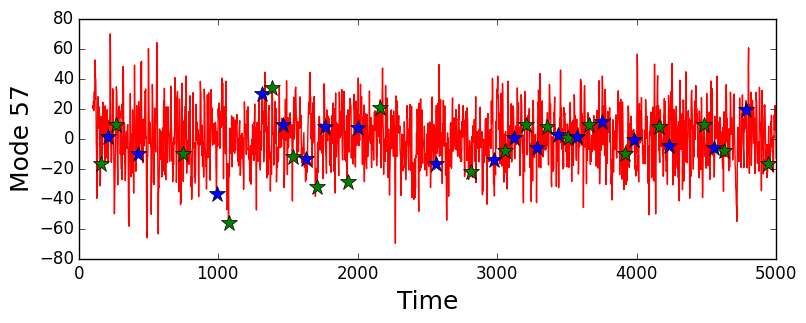

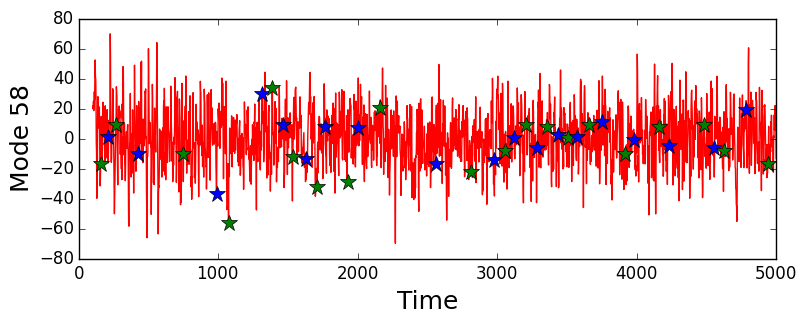

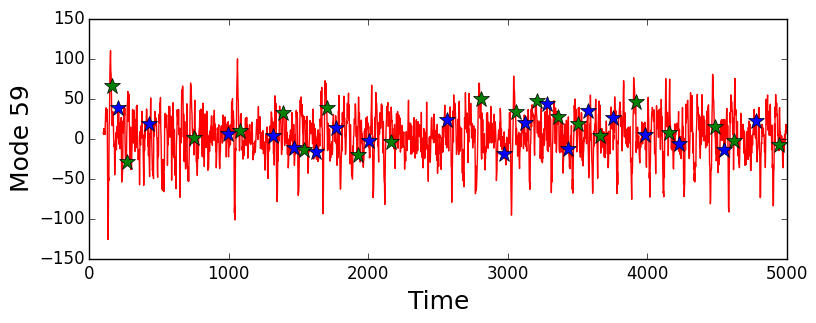

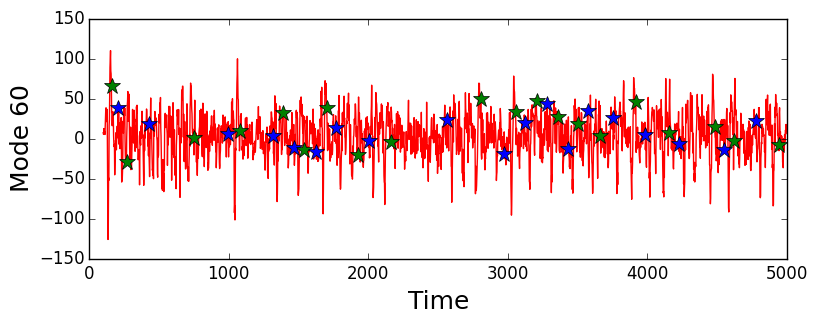

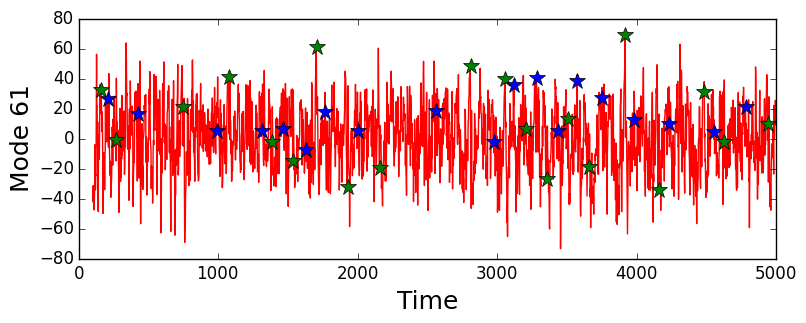

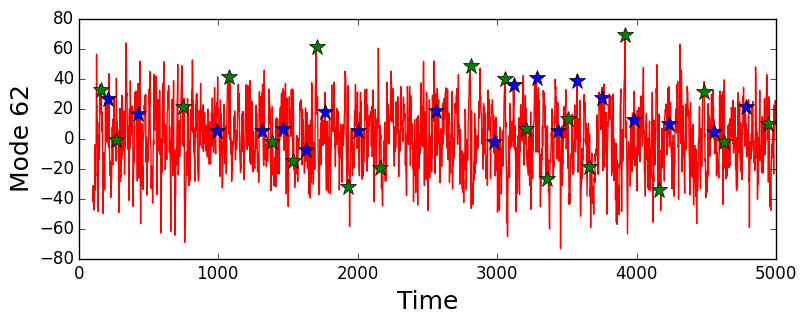

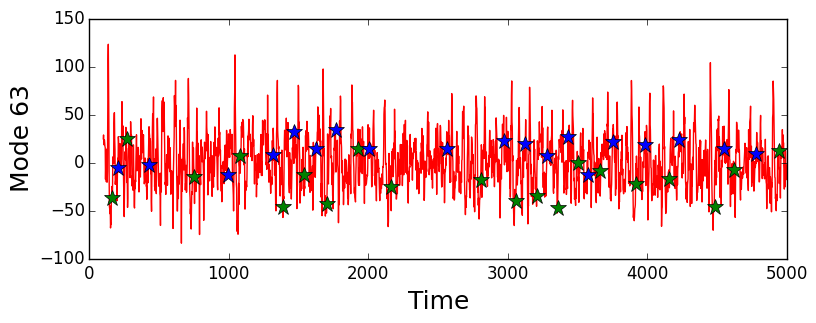

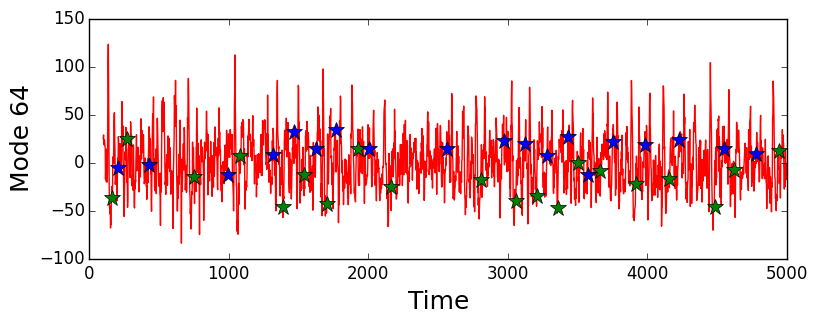

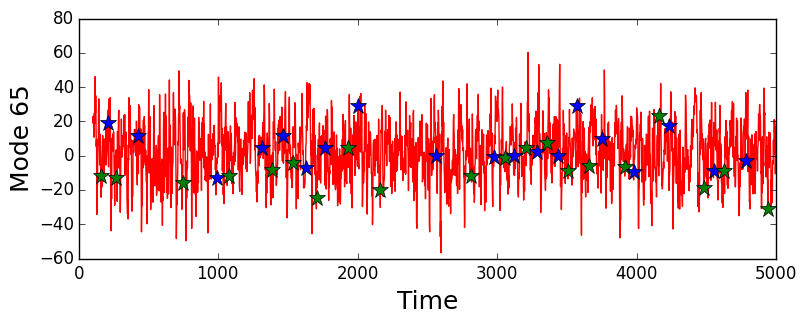

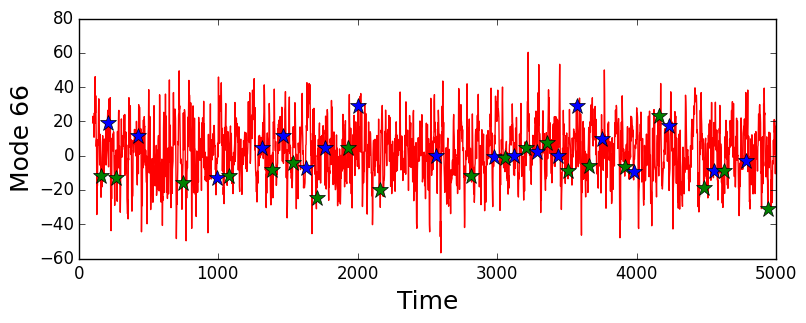

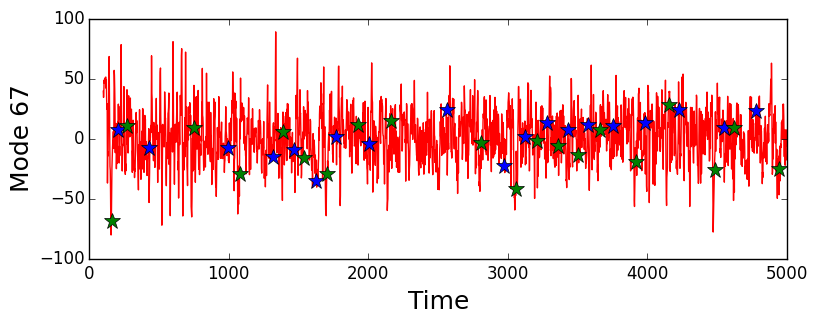

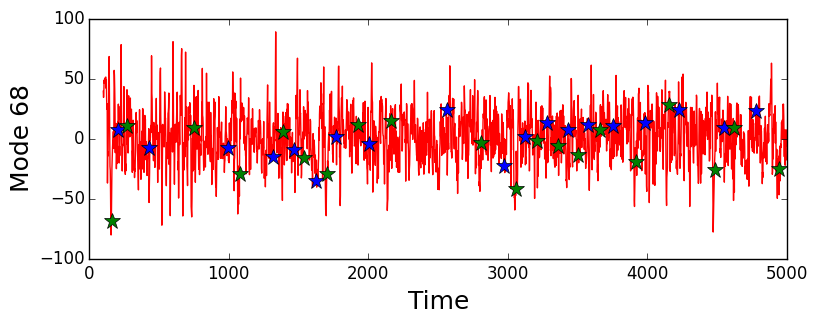

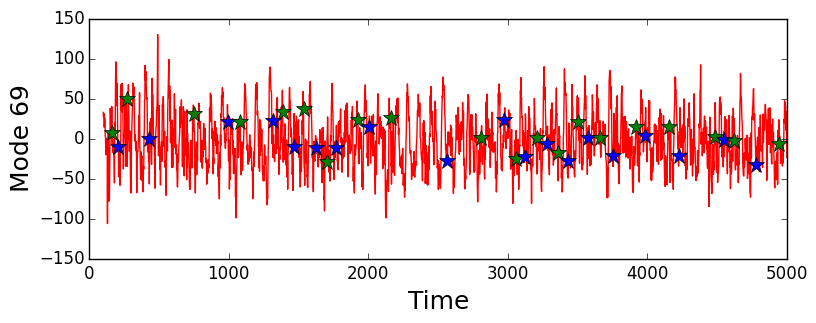

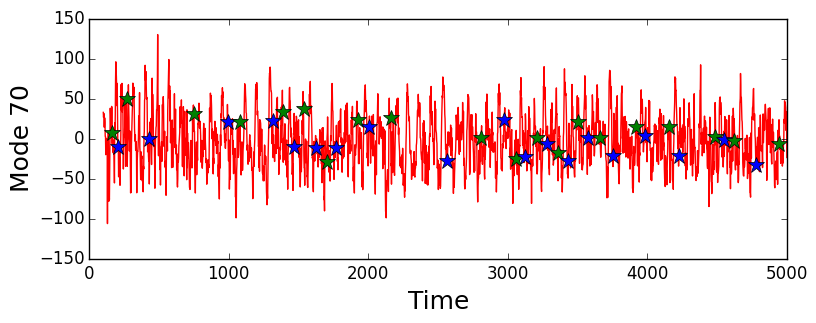

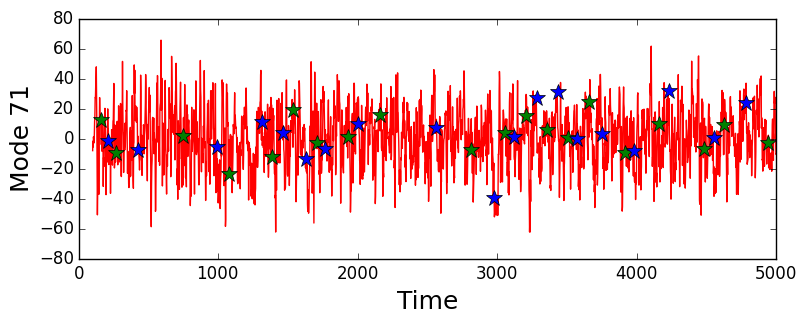

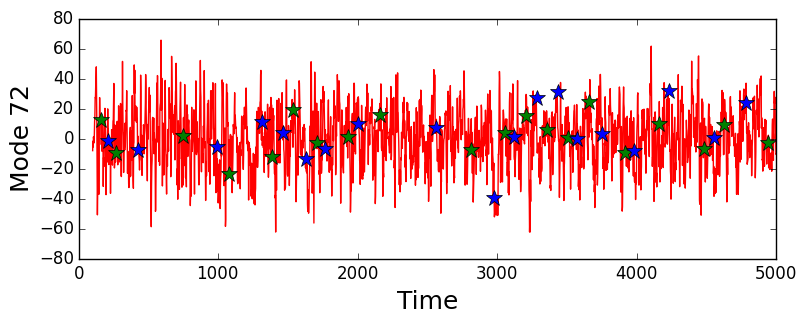

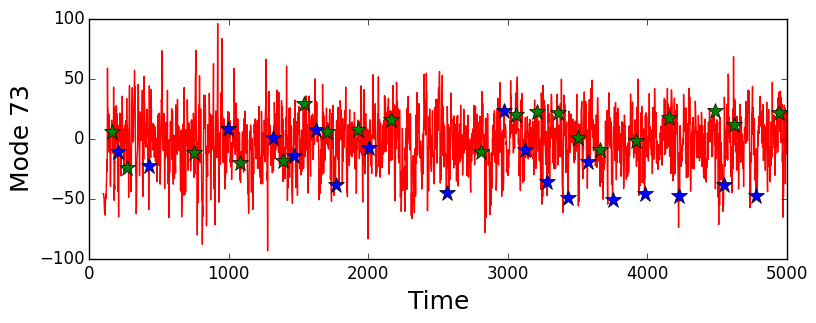

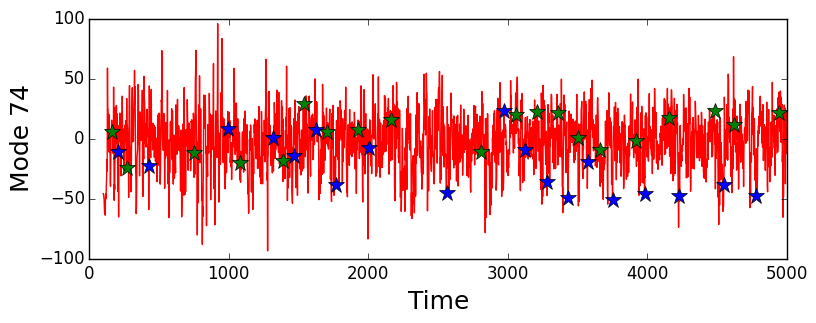

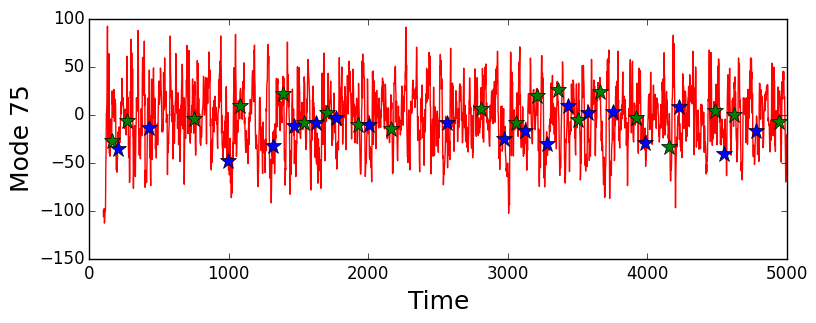

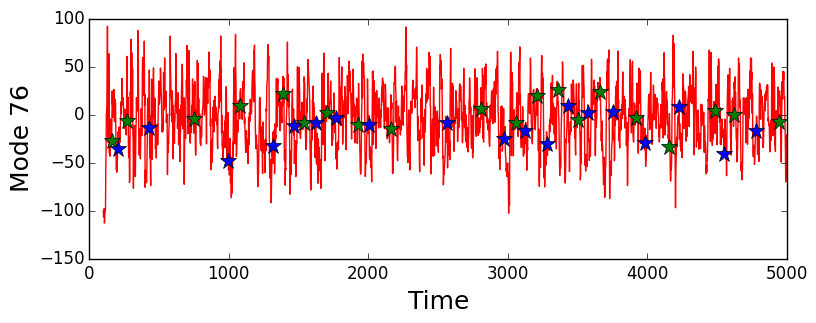

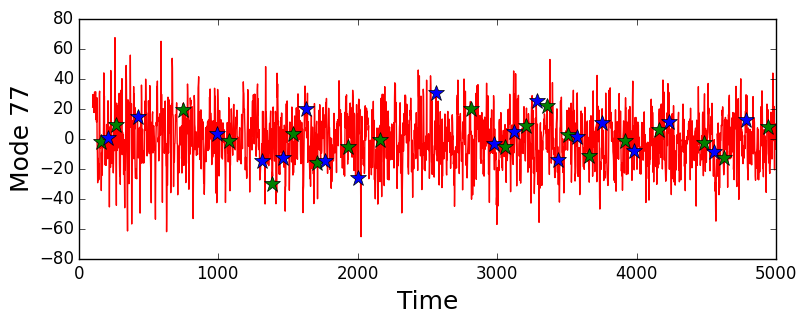

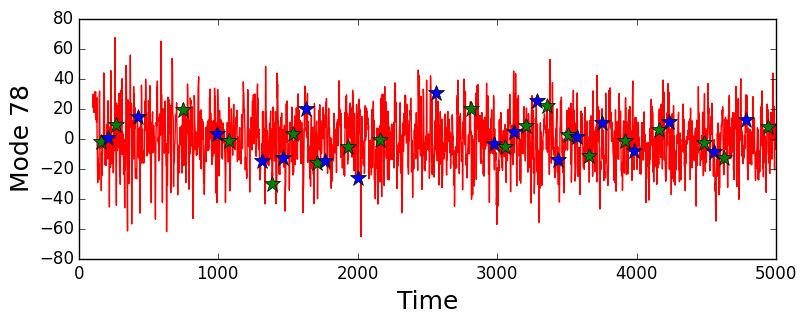

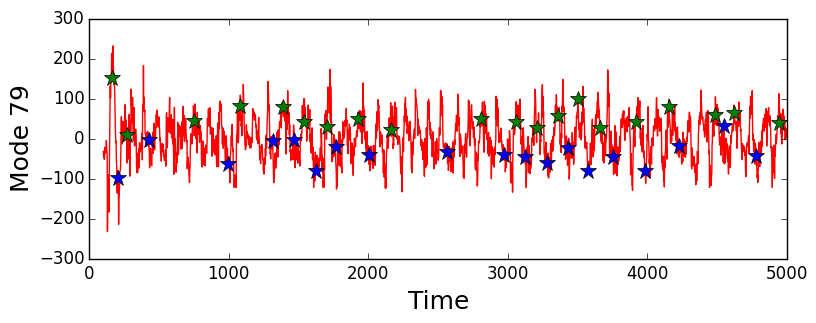

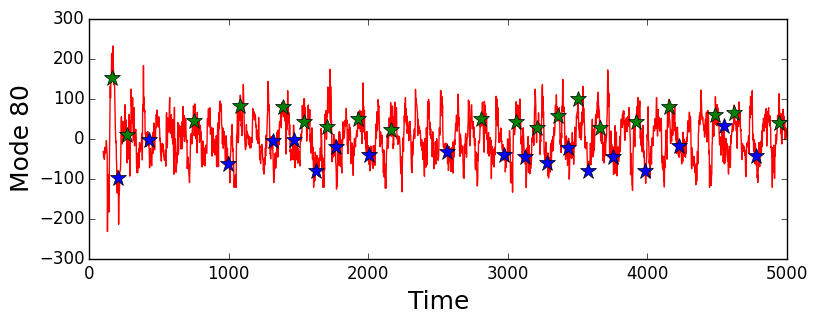

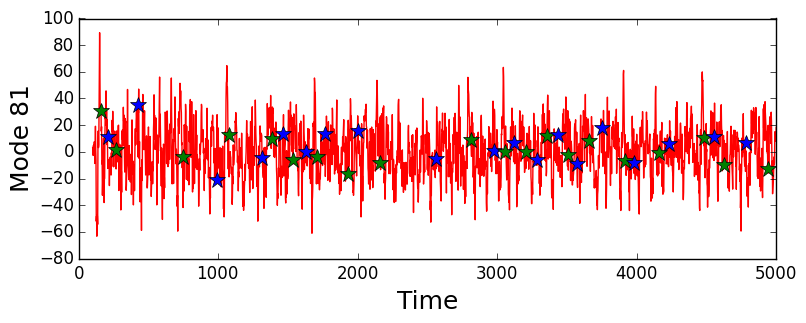

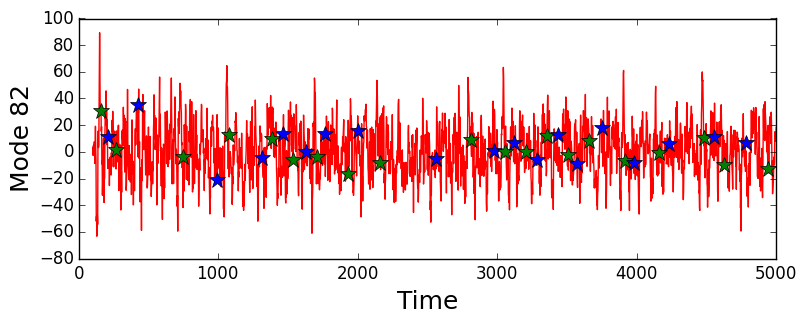

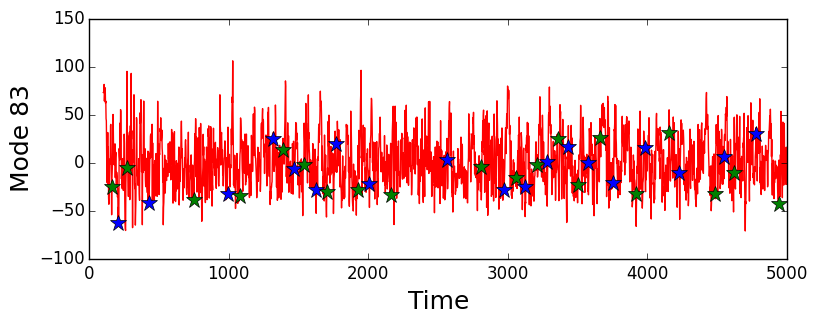

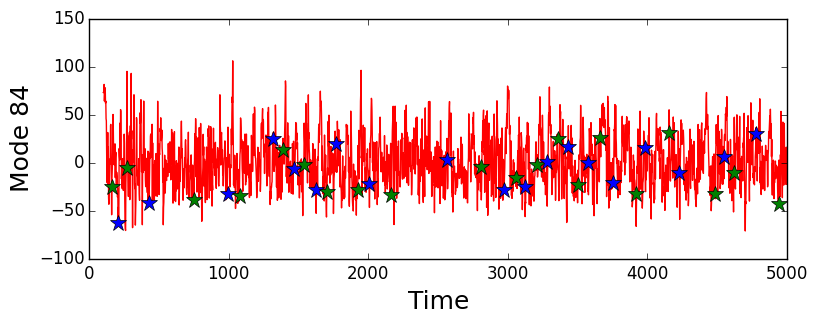

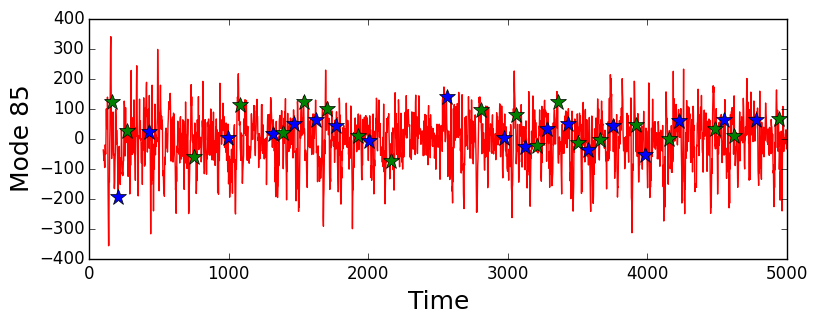

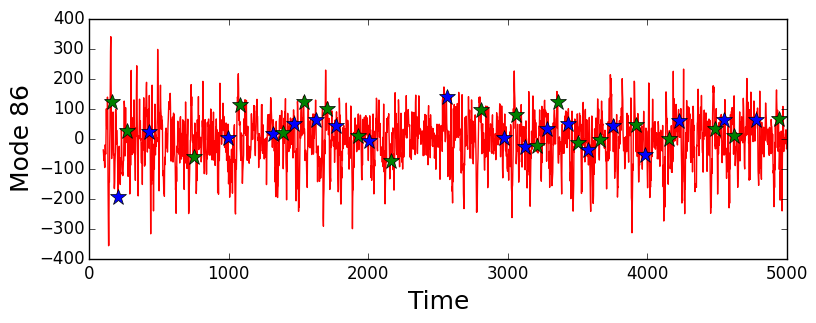

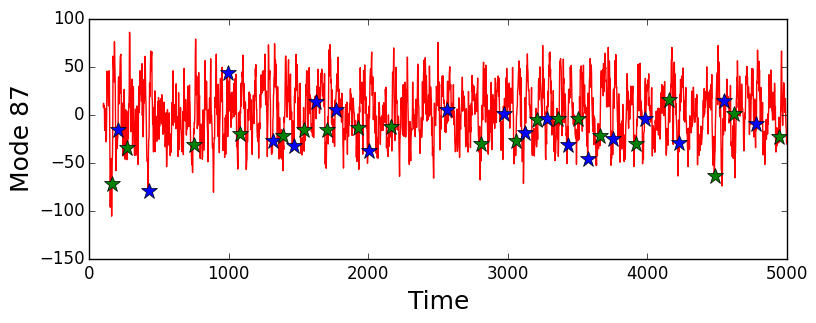

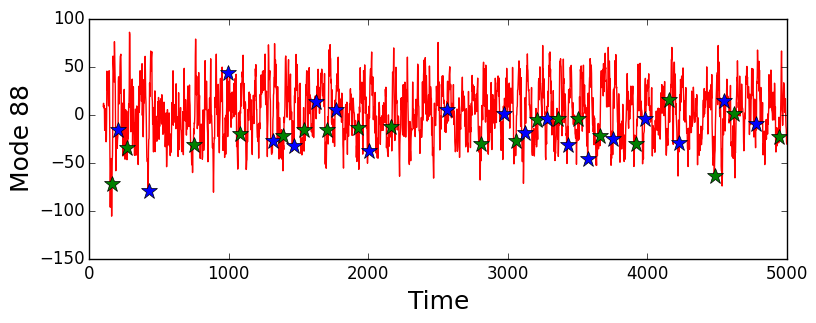

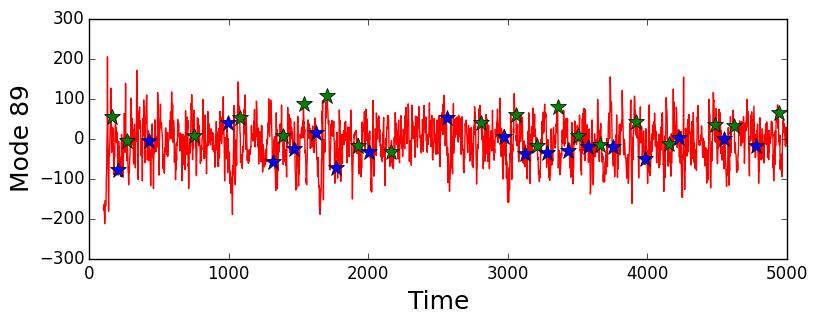

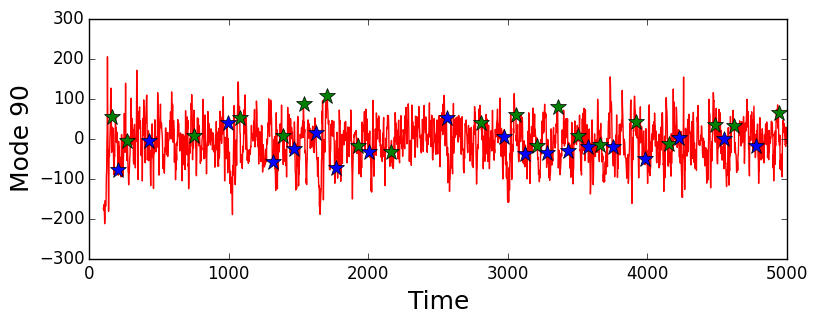

In [44]:
for mode=1:90
    plot_mode_timeseries(mode)
    # plot_mode_histogram(mode)
    # plot_mode_histogram_abs(mode)
end

In [32]:
(reversal_times-101)

39-element Array{Float64,1}:
   60.0
  108.0
  168.0
  324.0
  646.0
  890.0
  976.0
 1216.0
 1288.0
 1364.0
 1436.0
 1526.0
 1604.0
    ⋮  
 3474.0
 3560.0
 3652.0
 3818.0
 3882.0
 4056.0
 4128.0
 4382.0
 4450.0
 4522.0
 4680.0
 4842.0

In [33]:
longer_times

100:2:5000

In [34]:
size(all_projects[:,4])

(2451,)

In [45]:
figure(figsize=(7,7))
mode1 = 2
mode2 = 79
plot(all_projects[:,mode1],all_projects[:,mode2],"r.")
for i=1:length(reversal_times)
    if mod(i,2) == 0
        plot(all_projects[:,mode1][(reversal_times[i]-101)/2],all_projects[:,mode2][(reversal_times[i]-101)/2],"*",markersize=15,color="b",label="CW")
    else
        plot(all_projects[:,mode1][(reversal_times[i]-101)/2],all_projects[:,mode2][(reversal_times[i]-101)/2],"*",markersize=15,color="g",label="CCW")
    end
end
# plot(all_projects[:,mode1][(reversal_times-101)/2],all_projects[:,mode2][(reversal_times-101)/2],"*",markersize=15)
# ax.yaxis.tick_right()
ylabel("Mode $(mode1)",size=18)
xlabel("Mode $(mode2)",size=18)
legend(["No Reversal","CCW Reversal","CW Reversal"],loc="best")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD_mode_$(mode1)_$(mode2)_phaseplane-003.png",bbox_inches="tight")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD_mode_$(mode1)_$(mode2)_phaseplane-003.pdf",bbox_inches="tight")

LoadError: ax not defined
while loading In[45], in expression starting on line 13

In [36]:
mod(10,2) == 0

true